# preprocess_kdd_large.ipynb

# TGAT Preprocessing for Large Datasets
This notebook handles the preprocessing of KDD-like datasets, optimized for larger files using Dask.
It performs the following steps:
1. Loads raw data in chunks.
2. Defines column names and types.
3. Preprocesses labels (binary and multi-class).
4. Preprocesses features:
   - One-hot encodes categorical features using Dask's `get_dummies`.
   - Scales numerical features using Dask's mean/std.
5. Constructs temporal graph components (node features `x`, edge indices `edge_index`, timestamps `ts`).
6. Saves the processed data and metadata for the training script.

## 1. Setup & Configuration

In [2]:
# --- Environment Setup ---
# Make sure torch is installed first if not already
# %pip install torch torchvision torchaudio
import torch
import os

%pip install --upgrade pip setuptools wheel

# Install PyTorch Geometric core dependencies (adjust torch version and cuda suffix as needed)
TORCH_VERSION = torch.__version__.split('+')[0] # Get base torch version
CUDA_VERSION = torch.version.cuda.replace('.', '') if torch.cuda.is_available() else 'cpu'
CUDA_SUFFIX = f'cu{CUDA_VERSION}' if CUDA_VERSION != 'cpu' else 'cpu'
print(f"Installing PyG dependencies for Torch {TORCH_VERSION} and CUDA {CUDA_SUFFIX}...")
%pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+{CUDA_SUFFIX}.html

# --- Install pyg-lib for potential speedup (addresses warning) ---
print(f"Installing pyg-lib for Torch {TORCH_VERSION} and CUDA {CUDA_SUFFIX}...")
%pip install pyg_lib -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+{CUDA_SUFFIX}.html
# ------------------------------------------------------------------

%pip install "torch_geometric==2.6.1"
%pip install "torch-geometric-temporal==0.56.0"

# Other necessary libraries
%pip install pandas numpy scikit-learn matplotlib seaborn tqdm requests dask

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.35.1
    Uninstalling wheel-0.35.1:
      Successfully uninstalled wheel-0.35.1
  Attempting uninstall: setuptools
    Found existing installation: setuptools 69.0.3
    Uninstalling setuptools-69.0.3:
      Successfully uninstalled setuptools-69.0.3
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradient-utils 0.5.0 requires wheel<0.36.0,>=0.35.1, but you have wheel 0.45.1 which is incompatible.
gradient 2.0.6 r

## Cell 2: Imports and Configuration

In [62]:
import os
import pandas as pd # 確保導入 pandas
import numpy as np
import dask.dataframe as dd
import torch
import json
# from tqdm import tqdm # tqdm 在 Dask 的直接 compute 中不那麼直觀

# --- Configuration ---
RAW_DATA_DIR = './data/' 
TRAIN_FILE = 'KDDTrain+_20Percent.txt' 
TEST_FILE = 'KDDTest+.txt'      

PROCESSED_DATA_DIR = './processed_data_large/'
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

PROCESSED_TRAIN_FILE = os.path.join(PROCESSED_DATA_DIR, 'train_temporal_data.pt')
PROCESSED_TEST_FILE = os.path.join(PROCESSED_DATA_DIR, 'test_temporal_data.pt')
METADATA_FILE = os.path.join(PROCESSED_DATA_DIR, 'metadata.json')

HIDDEN_DIM = 256  # Define HIDDEN_DIM for TGAT

# --- NEW Parameters for Smarter Sampling in TemporalNeighborLoader (add these) ---
RECENCY_BIAS_FACTOR = 0.9                 # Example: Value between 0 (strong bias) and <1. 0 means no bias beyond sorting.
FEATURE_SIMILARITY_COL_NAME = 'service'   # Example: Column name from raw data for similarity. Set to None to disable.
FEATURE_SIMILARITY_WEIGHT = 0.3           # Example: Weight for similarity (0 to 1). 0 means no similarity bias.
EARLY_STOPPING_PATIENCE = 20              # Example: If you moved this from train_pipeline to global

BATCH_SIZE_SEQ_EMBED_GEN = 128  # Example
SEQUENCE_LENGTH = 15            # Example: Number of events in a sequence
STEP_SIZE = 5                   # Example: Sliding window step
SEQ_LABEL_MODE = 'any_attack'     # 'any_attack', 'all_attack', 'majority_attack'
BATCH_SIZE_SEQ_MODEL = 64       # Example
LEARNING_RATE_SEQ_MODEL = 1e-4  # Example
EPOCHS_SEQ_MODEL = 30           # Example
SEQ_MODEL_EMBEDDING_DIM = HIDDEN_DIM # This should be the dimension of embeddings from TGAT
                                     # For example, if TGAT's last hidden layer before MLP is HIDDEN_DIM
SEQ_MODEL_HIDDEN_DIM = 128       # Example
SEQ_MODEL_NUM_LAYERS = 2          # Example
SEQ_MODEL_RNN_TYPE = 'GRU'        # 'GRU' or 'LSTM'
SEQ_MODEL_DROPOUT = 0.3           # Example

COL_NAMES = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'attack_type', 'difficulty_score'
]

CATEGORICAL_COLS = ['protocol_type', 'service', 'flag']
NUMERICAL_COLS = [col for col in COL_NAMES if col not in CATEGORICAL_COLS + ['attack_type', 'difficulty_score']]
LABEL_COL = 'attack_type'
NORMAL_TAG = 'normal'

ATTACK_MAP_MULTI_CLASS = { 
    'normal': 0, 'dos': 1, 'probe': 2, 'r2l': 3, 'u2r': 4
}
KDD_SPECIFIC_TO_GENERAL_ATTACK_MAP = {
    'back': 'dos', 'land': 'dos', 'neptune': 'dos', 'pod': 'dos', 'smurf': 'dos', 'teardrop': 'dos',
    'mailbomb': 'dos', 'apache2': 'dos', 'processtable': 'dos', 'udpstorm': 'dos', 
    'ipsweep': 'probe', 'nmap': 'probe', 'portsweep': 'probe', 'satan': 'probe', 'mscan': 'probe', 'saint': 'probe', 
    'ftp_write': 'r2l', 'guess_passwd': 'r2l', 'imap': 'r2l', 'multihop': 'r2l', 'phf': 'r2l',
    'spy': 'r2l', 'warezclient': 'r2l', 'warezmaster': 'r2l', 'sendmail': 'r2l', 'named': 'r2l',
    'snmpgetattack': 'r2l', 'snmpguess': 'r2l', 'xlock': 'r2l', 'xsnoop': 'r2l', 'worm': 'r2l', 
    'buffer_overflow': 'u2r', 'loadmodule': 'u2r', 'perl': 'u2r', 'rootkit': 'u2r',
    'httptunnel': 'u2r', 'ps': 'u2r', 'sqlattack': 'u2r', 'xterm': 'u2r' 
}
UNKNOWN_ATTACK_CATEGORY_ID = max(ATTACK_MAP_MULTI_CLASS.values()) + 1

## 3. Preprocessing Functions

In [63]:
# Cell 4: Label Preprocessing Function
def preprocess_labels_event_node_dask(df_chunk: pd.DataFrame) -> pd.DataFrame:
    """ Preprocesses labels for a chunk of data (Pandas DataFrame). """
    df_chunk['label_binary'] = df_chunk[LABEL_COL].apply(lambda x: 0 if x == NORMAL_TAG else 1)
    
    def map_to_general_cat_id(attack_name):
        if attack_name == NORMAL_TAG:
            return ATTACK_MAP_MULTI_CLASS[NORMAL_TAG]
        general_category = KDD_SPECIFIC_TO_GENERAL_ATTACK_MAP.get(attack_name)
        if general_category:
            return ATTACK_MAP_MULTI_CLASS.get(general_category, UNKNOWN_ATTACK_CATEGORY_ID)
        return UNKNOWN_ATTACK_CATEGORY_ID

    df_chunk['label_multiclass_id'] = df_chunk[LABEL_COL].apply(map_to_general_cat_id)
    return df_chunk[['label_binary', 'label_multiclass_id']]

In [64]:
# Cell: Feature Scaler Fitting and Category Info (Minor refinement in comment/consistency)
def fit_scalers_and_get_categories_info(ddf: dd.DataFrame, numerical_cols: list, categorical_cols: list):
    """
    Computes means/stds for numerical columns and gets categorical feature names after one-hot encoding.
    Assumes ddf[numerical_cols] contains numeric data and ddf[categorical_cols] has been categorized.
    """
    print("Fitting scalers and determining categorical feature names...")
    # Numerical part remains the same
    computed_means = ddf[numerical_cols].mean().compute()
    computed_stds = ddf[numerical_cols].std().compute()
    computed_stds = computed_stds.where(computed_stds != 0, 1.0) 

    # Categorical part: ddf[categorical_cols] should already have 'category' dtype with known categories
    # from the .categorize() call in the main preprocessing function.
    # So, ddf_cat_casted is essentially ddf[categorical_cols]
    ddf_cat_subset = ddf[categorical_cols] 
    
    # Get schema of dummy columns from a small sample for consistency.
    # Since categories are known, head(1) or head(2) should be sufficient for schema.
    # Compute=True is needed as head() is lazy.
    sample_for_schema = ddf_cat_subset.head(max(2, ddf_cat_subset.npartitions if ddf_cat_subset.npartitions > 0 else 2), compute=True) 
    if sample_for_schema.empty and not ddf_cat_subset.known_divisions: # If dataframe is empty or structure is unknown after categorize
        print("Warning: Categorical subset for dummy schema is empty or has unknown divisions. Using predefined columns for schema.")
        # Fallback to creating an empty DataFrame with expected columns if sample is problematic
        # This might happen if the initial ddf was empty.
        # This part might need more robust handling depending on how empty Dask DFs behave with categorize
        categorical_feature_names_fitted = [] # Or load from a predefined schema if truly empty
        if not ddf[categorical_cols].head(1).empty: # try again just in case.
            dummy_ddf_schema = dd.get_dummies(ddf[categorical_cols].head(1), columns=categorical_cols, prefix=categorical_cols, dummy_na=False)
            categorical_feature_names_fitted = list(dummy_ddf_schema.columns)

    elif not sample_for_schema.empty:
         dummy_ddf_schema = pd.get_dummies(sample_for_schema, columns=categorical_cols, prefix=categorical_cols, dummy_na=False)
         categorical_feature_names_fitted = list(dummy_ddf_schema.columns)
    else: # Fallback if sample_for_schema is empty but ddf_cat_subset was not entirely empty
        print("Warning: Could not reliably determine dummy schema from sample. Categorical feature names might be incomplete.")
        categorical_feature_names_fitted = [f"{col}_{cat}" for col in categorical_cols for cat in ddf_cat_subset[col].cat.categories]


    print(f"Scalers determined. Categorical feature names derived: {len(categorical_feature_names_fitted)} features.")
    return computed_means, computed_stds, categorical_feature_names_fitted

## 6. Main Preprocessing Orchestration (Function Definition)

In [65]:
# Cell: Main Preprocessing Logic Function (CORRECTED for Warnings)
def preprocess_and_save_temporal_data(raw_file_path: str, output_file_path: str,
                                      numerical_cols_original_config: list,
                                      categorical_cols: list, label_col: str,
                                      is_training_set: bool = False,
                                      fitted_scalers_and_cats_info: dict = None,
                                      recent_window_size: int = 50):
    """ Reads, preprocesses, and saves temporal data components. """
    print(f"Starting preprocessing for: {raw_file_path}")

    current_numerical_cols = list(numerical_cols_original_config)
    dtype_initial_read = {col: 'object' for col in COL_NAMES}

    try:
        ddf = dd.read_csv(raw_file_path, header=None, names=COL_NAMES, dtype=dtype_initial_read, blocksize='256MB', usecols=COL_NAMES)
    except Exception as e:
        print(f"Dask read_csv error for {raw_file_path}: {e}. Attempting Pandas fallback.")
        df_chunks_list = []
        for chunk_pd in pd.read_csv(raw_file_path, header=None, names=COL_NAMES, chunksize=100000, low_memory=False, dtype=str, usecols=COL_NAMES):
             df_chunks_list.append(chunk_pd)
        if not df_chunks_list:
            raise ValueError(f"Pandas fallback failed: No data read from {raw_file_path}")
        full_df_pandas = pd.concat(df_chunks_list, ignore_index=True)
        nparts = max(1, int(np.ceil(len(full_df_pandas) / 500000)))
        ddf = dd.from_pandas(full_df_pandas, npartitions=nparts)
        print(f"Pandas fallback to Dask DF successful with {nparts} partitions.")

    print("Converting original numerical columns to numeric type...")
    for col in numerical_cols_original_config:
        if col in ddf.columns:
            ddf[col] = dd.to_numeric(ddf[col], errors='coerce').fillna(0)
        else:
            print(f"Warning: Original numerical column '{col}' not found in ddf during initial conversion for {raw_file_path}.")

    if 'temp_event_timestamp' not in ddf.columns:
        ddf['temp_event_timestamp'] = ddf.index.astype(np.int64)
    else:
        ddf['temp_event_timestamp'] = dd.to_numeric(ddf['temp_event_timestamp'], errors='coerce').fillna(0).astype(np.int64)

    print("Resetting index to prepare for setting a known, sorted index...")
    ddf = ddf.reset_index()
    index_col_name_after_reset = 'index'
    if index_col_name_after_reset not in ddf.columns and 'level_0' in ddf.columns:
        index_col_name_after_reset = 'level_0'
    elif index_col_name_after_reset not in ddf.columns and 0 in ddf.columns and ddf.columns[0] == 0 :
        ddf = ddf.rename(columns={0: index_col_name_after_reset})
    if index_col_name_after_reset not in ddf.columns:
        if ddf.columns[0] not in COL_NAMES and ddf.columns[0] not in categorical_cols and ddf.columns[0] not in numerical_cols_original_config:
            print(f"Warning: Reset index column name '{index_col_name_after_reset}' not found. Trying to use first column '{ddf.columns[0]}' as index.")
            index_col_name_after_reset = ddf.columns[0]
        else:
            raise ValueError(f"Could not identify the reset index column. Columns are: {ddf.columns}")
    print(f"Setting '{index_col_name_after_reset}' as new sorted index...")
    ddf = ddf.set_index(index_col_name_after_reset, drop=True, sorted=True)

    print("Persisting ddf after setting new index...")
    ddf = ddf.persist()
    print(f"After set_index & persist: ddf npartitions: {ddf.npartitions}, divisions known: {ddf.known_divisions}, divisions: {ddf.divisions}")
    if not ddf.known_divisions:
         print("CRITICAL WARNING: Base ddf still has unknown divisions after set_index(sorted=True) and persist.")

    print(f"Ensuring specified categorical columns ({categorical_cols}) are 'category' dtype...")
    actual_categorical_cols_in_ddf = []
    for col in categorical_cols:
        if col in ddf.columns:
            # MODIFICATION: Replace deprecated is_categorical_dtype
            if not isinstance(ddf[col].dtype, pd.CategoricalDtype):
                 ddf[col] = ddf[col].astype('category')
            actual_categorical_cols_in_ddf.append(col)
        else:
            print(f"Warning: Categorical column '{col}' not found in ddf for {raw_file_path}.")

    print(f"Categorizing columns: {actual_categorical_cols_in_ddf}")
    if actual_categorical_cols_in_ddf:
        ddf = ddf.categorize(columns=actual_categorical_cols_in_ddf)
    else:
        print("Warning: No specified categorical columns found in ddf to categorize.")

    print("Persisting ddf after categorization...")
    ddf = ddf.persist()
    print(f"After categorize & persist: ddf npartitions: {ddf.npartitions}, divisions known: {ddf.known_divisions}, divisions: {ddf.divisions}")

    print(f"Starting enhanced feature engineering with window size: {recent_window_size}...")
    newly_engineered_feature_cols = []

    PROXY_SRC_IP_COL = 'service'
    PROXY_DST_IP_COL = 'dst_host_srv_count'
    PROXY_DST_PORT_COL = 'service'
    TIMESTAMP_COL = 'temp_event_timestamp'
    DURATION_COL = 'duration'

    if not all(c in ddf.columns for c in [PROXY_SRC_IP_COL, TIMESTAMP_COL]):
        print(f"Skipping 'time_since_last_event...' due to missing required columns: {PROXY_SRC_IP_COL} or {TIMESTAMP_COL}")
    else:
        new_feat_time_since_last_src_proxy = f'time_since_last_event_same_{PROXY_SRC_IP_COL}_proxy'
        # MODIFICATION: Change meta for ddf.groupby.transform to be a Pandas Series
        meta_time_since = pd.Series(name=new_feat_time_since_last_src_proxy, dtype=np.int64) # Or float64 if diff can be float
        ddf[new_feat_time_since_last_src_proxy] = ddf.groupby(PROXY_SRC_IP_COL, observed=True)[TIMESTAMP_COL].transform(
            lambda x: x.diff().fillna(0),
            meta=meta_time_since # Use Pandas Series for meta
        ).astype(np.float32)
        newly_engineered_feature_cols.append(new_feat_time_since_last_src_proxy)
        print(f"Engineered feature: {new_feat_time_since_last_src_proxy}")

    group_cols_for_avg_duration = [PROXY_DST_PORT_COL, PROXY_DST_IP_COL]
    if not all(col in ddf.columns for col in group_cols_for_avg_duration) or DURATION_COL not in ddf.columns:
        print(f"Skipping 'avg_duration_recent...' due to missing columns for grouping or value ({group_cols_for_avg_duration}, {DURATION_COL}).")
    else:
        new_feat_avg_duration_proxy = f'avg_duration_recent_same_{PROXY_DST_PORT_COL}_{PROXY_DST_IP_COL}_proxy'
        if PROXY_DST_IP_COL in ddf.columns and pd.api.types.is_float_dtype(ddf[PROXY_DST_IP_COL].dtype):
            ddf[PROXY_DST_IP_COL] = ddf[PROXY_DST_IP_COL].astype(int)

        def expanding_avg_duration_partition(df_partition, group_cols_list_internal, val_col_internal, new_col_name_internal):
            if not df_partition.empty and all(c in df_partition.columns for c in group_cols_list_internal) and val_col_internal in df_partition.columns:
                for group_col_check in group_cols_list_internal:
                     if pd.api.types.is_numeric_dtype(df_partition[group_col_check]) and df_partition[group_col_check].nunique() > 200 and len(df_partition) > 1000:
                        print(f"Warning: Grouping by high-cardinality numeric column '{group_col_check}' in expanding_avg_duration_partition within a partition.")
                try:
                    df_partition[new_col_name_internal] = df_partition.groupby(group_cols_list_internal, observed=True)[val_col_internal].transform(
                        lambda x: x.expanding().mean().fillna(0)
                    )
                except Exception as e_gb_transform:
                    print(f"Error in expanding_avg_duration_partition's groupby/transform: {e_gb_transform}. Filling with 0.")
                    df_partition[new_col_name_internal] = pd.Series(0, index=df_partition.index, dtype=np.float32)
            else:
                df_partition[new_col_name_internal] = pd.Series(0, index=df_partition.index, dtype=np.float32)
            return df_partition[new_col_name_internal]

        meta_avg_duration = pd.Series(name=new_feat_avg_duration_proxy, dtype=np.float32)
        ddf[new_feat_avg_duration_proxy] = ddf.map_partitions(
            expanding_avg_duration_partition,
            group_cols_list_internal=group_cols_for_avg_duration,
            val_col_internal=DURATION_COL,
            new_col_name_internal=new_feat_avg_duration_proxy,
            meta=meta_avg_duration
        ).astype(np.float32)
        newly_engineered_feature_cols.append(new_feat_avg_duration_proxy)
        print(f"Engineered feature: {new_feat_avg_duration_proxy}")

    if PROXY_SRC_IP_COL not in ddf.columns:
        print(f"Skipping 'count_recent_same_service_cum_proxy' as {PROXY_SRC_IP_COL} is missing.")
    else:
        new_feat_count_recent_src_proxy = f'count_recent_same_{PROXY_SRC_IP_COL}_cum_proxy'
        ddf[new_feat_count_recent_src_proxy] = ddf.groupby(PROXY_SRC_IP_COL, observed=True).cumcount().astype(np.float32)
        newly_engineered_feature_cols.append(new_feat_count_recent_src_proxy)
        print(f"Engineered feature: {new_feat_count_recent_src_proxy}")

    ddf = ddf.persist()
    print(f"Finished enhanced feature engineering. Successfully added columns: {newly_engineered_feature_cols}")

    if label_col in ddf.columns:
        meta_labels_df = pd.DataFrame({'label_binary': pd.Series(dtype='int'), 'label_multiclass_id': pd.Series(dtype='int')})
        processed_labels_ddf = ddf.map_partitions(preprocess_labels_event_node_dask, meta=meta_labels_df)
    else:
        print(f"Warning: Label column '{label_col}' not found in ddf for {raw_file_path}. Creating dummy labels.")
        num_rows_approx = ddf.map_partitions(len).compute().sum() if ddf.npartitions > 0 else 0
        dummy_labels_data = {'label_binary': np.zeros(num_rows_approx, dtype=int),
                             'label_multiclass_id': np.zeros(num_rows_approx, dtype=int)}
        processed_labels_ddf = dd.from_pandas(pd.DataFrame(dummy_labels_data), npartitions=ddf.npartitions if ddf.npartitions > 0 else 1)

    print("Preprocessing features...")
    current_numerical_cols.extend([col for col in newly_engineered_feature_cols if col in ddf.columns and col not in current_numerical_cols])
    print(f"Final numerical_cols for scaling consideration: {current_numerical_cols}")

    scaler_params_to_return_or_use = {}
    cat_feat_names_final = []

    if is_training_set:
        actual_numerical_cols_for_fit = [col for col in current_numerical_cols if col in ddf.columns]
        actual_categorical_cols_for_dummies = [col for col in categorical_cols if col in ddf.columns] # For get_dummies
        
        # fit_scalers_and_get_categories_info expects categorized columns.
        # actual_categorical_cols_in_ddf are the ones that have been .astype('category') and ddf.categorize'd
        
        if not actual_numerical_cols_for_fit:
            print("Warning: No numerical columns available for fitting scalers during training. Scalers will be empty.")
            fitted_means = pd.Series(dtype=float)
            fitted_stds = pd.Series(dtype=float)
        else:
            fitted_means, fitted_stds, cat_feat_names_from_scaler_func = fit_scalers_and_get_categories_info(
                ddf,
                actual_numerical_cols_for_fit,
                actual_categorical_cols_in_ddf # These are already categorized
            )
        cat_feat_names_final = cat_feat_names_from_scaler_func

        scaler_params_to_return_or_use = {
            'means': fitted_means.to_dict(), 'stds': fitted_stds.to_dict(),
            'categorical_feature_names': cat_feat_names_final,
            'all_numerical_cols_scaled': list(actual_numerical_cols_for_fit)
        }
    else: # Test set
        if fitted_scalers_and_cats_info is None:
            raise ValueError("fitted_scalers_and_cats_info must be provided for non-training sets.")
        fitted_means = pd.Series(fitted_scalers_and_cats_info['means'])
        fitted_stds = pd.Series(fitted_scalers_and_cats_info['stds'])
        cat_feat_names_final = fitted_scalers_and_cats_info['categorical_feature_names']
        numerical_cols_scaled_during_training = fitted_scalers_and_cats_info.get('all_numerical_cols_scaled', [])
        current_numerical_cols = [col for col in numerical_cols_scaled_during_training if col in ddf.columns]
        missing_from_test_ddf = [col for col in numerical_cols_scaled_during_training if col not in ddf.columns]
        if missing_from_test_ddf:
            print(f"Warning: Numerical columns scaled during training are missing from test ddf: {missing_from_test_ddf}.")
            for col_m in missing_from_test_ddf:
                if col_m not in fitted_means: fitted_means[col_m] = 0.0
                if col_m not in fitted_stds: fitted_stds[col_m] = 1.0
        scaler_params_to_return_or_use = fitted_scalers_and_cats_info

    numerical_cols_to_scale_in_ddf = [col for col in current_numerical_cols if col in ddf.columns]
    if not numerical_cols_to_scale_in_ddf:
        print("Warning: No numerical columns to scale found in current ddf. Creating empty scaled_numerical_ddf.")
        num_rows_for_empty_df = ddf.map_partitions(len).compute().sum() if ddf.npartitions > 0 else 0
        scaled_numerical_ddf = dd.from_pandas(pd.DataFrame(index=pd.RangeIndex(num_rows_for_empty_df)),
                                              npartitions=ddf.npartitions if ddf.npartitions > 0 else 1).persist()
    else:
        numerical_df_slice = ddf[numerical_cols_to_scale_in_ddf]
        print(f"Persisting numerical_df_slice (cols: {numerical_cols_to_scale_in_ddf}) before map_partitions for scaling...")
        numerical_df_slice = numerical_df_slice.persist()
        print(f"numerical_df_slice persisted: npart={numerical_df_slice.npartitions}, known_div={numerical_df_slice.known_divisions}, div={numerical_df_slice.divisions}")

        def scale_partition_func(partition_pd_df, means_pd_series, stds_pd_series):
            cols_to_scale = partition_pd_df.columns
            aligned_means = means_pd_series.reindex(cols_to_scale).fillna(0)
            aligned_stds = stds_pd_series.reindex(cols_to_scale).fillna(1.0)
            aligned_stds[aligned_stds == 0] = 1.0
            return ((partition_pd_df - aligned_means) / aligned_stds).fillna(0)

        # Ensure meta_scaled_numerical is a pandas DataFrame matching the output structure
        # Use _meta_nonempty if available and non-empty, otherwise use _meta
        if hasattr(numerical_df_slice, '_meta_nonempty') and not numerical_df_slice._meta_nonempty.empty:
            meta_scaled_numerical = numerical_df_slice._meta_nonempty.copy().astype(float) # Ensure float for scaled output
        elif not numerical_df_slice._meta.empty:
            meta_scaled_numerical = numerical_df_slice._meta.copy().astype(float)
        else: # Fallback if meta is empty (e.g., slice was empty)
             meta_scaled_numerical = pd.DataFrame(columns=numerical_df_slice.columns, dtype=float)


        print("Applying scaling via map_partitions...")
        scaled_numerical_ddf = numerical_df_slice.map_partitions(
            scale_partition_func,
            means_pd_series=fitted_means,
            stds_pd_series=fitted_stds,
            meta=meta_scaled_numerical
        ).persist()

    print(f"scaled_numerical_ddf persisted: npart={scaled_numerical_ddf.npartitions}, known_div={scaled_numerical_ddf.known_divisions}, div={scaled_numerical_ddf.divisions}")

    if not actual_categorical_cols_in_ddf or not cat_feat_names_final:
        print("Warning: No categorical columns to process or no cat_feat_names defined. Creating empty aligned_processed_features_ddf_cat.")
        num_rows_for_empty_df = ddf.map_partitions(len).compute().sum() if ddf.npartitions > 0 else 0
        # Create an empty DataFrame with the correct index for alignment
        empty_cat_df_pd = pd.DataFrame(columns=cat_feat_names_final if cat_feat_names_final else [],
                                       index=pd.RangeIndex(num_rows_for_empty_df), dtype=np.int8)
        aligned_processed_features_ddf_cat = dd.from_pandas(empty_cat_df_pd,
                                                            npartitions=ddf.npartitions if ddf.npartitions > 0 else 1)
        if ddf.npartitions > 0 and num_rows_for_empty_df > 0 and ddf.index.name is not None: # Check if index is valid
            try:
                aligned_processed_features_ddf_cat = aligned_processed_features_ddf_cat.set_index(ddf.index)
            except Exception as e_set_index_empty:
                print(f"Could not set index for empty categorical df: {e_set_index_empty}. Proceeding with default index.")

        aligned_processed_features_ddf_cat = aligned_processed_features_ddf_cat.persist()
    else:
        # Use actual_categorical_cols_in_ddf which are confirmed to exist and are categorized
        processed_features_ddf_cat_raw = dd.get_dummies(ddf[actual_categorical_cols_in_ddf],
                                                        prefix=actual_categorical_cols_in_ddf, dummy_na=False)
        def align_partition_columns_func(partition_df, target_columns_list):
            aligned_partition = pd.DataFrame(0, index=partition_df.index, columns=target_columns_list)
            common_cols_in_partition = [col for col in partition_df.columns if col in target_columns_list]
            if common_cols_in_partition:
                aligned_partition[common_cols_in_partition] = partition_df[common_cols_in_partition]
            return aligned_partition.astype(np.int8)

        meta_for_aligned_cat = pd.DataFrame(columns=cat_feat_names_final, dtype=np.int8)
        aligned_processed_features_ddf_cat = processed_features_ddf_cat_raw.map_partitions(
            align_partition_columns_func, target_columns_list=cat_feat_names_final, meta=meta_for_aligned_cat
        ).persist()

    if ddf.known_divisions:
        print(f"Base ddf has known divisions: {ddf.divisions}. Enforcing these divisions on derived DFs.")
        if scaled_numerical_ddf.divisions != ddf.divisions :
             if not (scaled_numerical_ddf.npartitions == 1 and scaled_numerical_ddf.divisions[0] is None and scaled_numerical_ddf.divisions[1] is None):
                print(f"Aligning scaled_numerical_ddf divisions from ({scaled_numerical_ddf.divisions}) to base ddf ({ddf.divisions}).")
                scaled_numerical_ddf = scaled_numerical_ddf.repartition(divisions=ddf.divisions).persist()
        if aligned_processed_features_ddf_cat.divisions != ddf.divisions:
            if not (aligned_processed_features_ddf_cat.npartitions == 1 and aligned_processed_features_ddf_cat.divisions[0] is None and aligned_processed_features_ddf_cat.divisions[1] is None):
                print(f"Aligning aligned_cat_ddf divisions from ({aligned_processed_features_ddf_cat.divisions}) to base ddf ({ddf.divisions}).")
                aligned_processed_features_ddf_cat = aligned_processed_features_ddf_cat.repartition(divisions=ddf.divisions).persist()
    
    print(f"Before concat: Numerical npart={scaled_numerical_ddf.npartitions}, known_div={scaled_numerical_ddf.known_divisions}, div={scaled_numerical_ddf.divisions}, cols={len(scaled_numerical_ddf.columns)}")
    print(f"Before concat: Categorical npart={aligned_processed_features_ddf_cat.npartitions}, known_div={aligned_processed_features_ddf_cat.known_divisions}, div={aligned_processed_features_ddf_cat.divisions}, cols={len(aligned_processed_features_ddf_cat.columns)}")

    is_numerical_effectively_empty = len(scaled_numerical_ddf.columns) == 0 or (scaled_numerical_ddf.map_partitions(len).compute().sum() == 0)
    is_categorical_effectively_empty = len(aligned_processed_features_ddf_cat.columns) == 0 or (aligned_processed_features_ddf_cat.map_partitions(len).compute().sum() == 0)
    
    num_original_rows = ddf.map_partitions(len).compute().sum() if ddf.npartitions > 0 else 0

    if is_numerical_effectively_empty and is_categorical_effectively_empty:
        print("Both numerical and categorical feature sets are effectively empty. Resulting features will be zero array.")
        x_np = np.zeros((num_original_rows, 1 if num_original_rows > 0 else 0), dtype=np.float32)
    elif is_numerical_effectively_empty:
        print("Numerical features are effectively empty. Using only categorical features.")
        final_features_ddf = aligned_processed_features_ddf_cat.persist()
        x_np = final_features_ddf.compute().to_numpy(dtype=np.float32)
    elif is_categorical_effectively_empty:
        print("Categorical features are effectively empty. Using only numerical features.")
        final_features_ddf = scaled_numerical_ddf.persist()
        x_np = final_features_ddf.compute().to_numpy(dtype=np.float32)
    else:
        try:
            if not (scaled_numerical_ddf.known_divisions and aligned_processed_features_ddf_cat.known_divisions and scaled_numerical_ddf.divisions == aligned_processed_features_ddf_cat.divisions):
                 print("Divisions mismatch or unknown before concat, attempting repartition to base ddf divisions or npartitions.")
                 if ddf.known_divisions:
                    if scaled_numerical_ddf.divisions != ddf.divisions: scaled_numerical_ddf = scaled_numerical_ddf.repartition(divisions=ddf.divisions).persist()
                    if aligned_processed_features_ddf_cat.divisions != ddf.divisions: aligned_processed_features_ddf_cat = aligned_processed_features_ddf_cat.repartition(divisions=ddf.divisions).persist()
                 else:
                     target_nparts = ddf.npartitions if ddf.npartitions > 0 else 1
                     if scaled_numerical_ddf.npartitions != target_nparts: scaled_numerical_ddf = scaled_numerical_ddf.repartition(npartitions=target_nparts).persist()
                     if aligned_processed_features_ddf_cat.npartitions != target_nparts: aligned_processed_features_ddf_cat = aligned_processed_features_ddf_cat.repartition(npartitions=target_nparts).persist()

            if (scaled_numerical_ddf.known_divisions and
                aligned_processed_features_ddf_cat.known_divisions and
                scaled_numerical_ddf.divisions == aligned_processed_features_ddf_cat.divisions):
                print("Attempting dd.concat with known and matching divisions.")
                final_features_ddf = dd.concat([scaled_numerical_ddf, aligned_processed_features_ddf_cat], axis=1, interleave_partitions=False) # Try False for interleave
            else:
                print("Divisions still unknown or mismatching for concat. Falling back to dd.merge on index after reset.")
                df1_indexed = scaled_numerical_ddf.reset_index()
                df2_indexed = aligned_processed_features_ddf_cat.reset_index()
                merge_on_col = 'index'
                if merge_on_col not in df1_indexed.columns and 'level_0' in df1_indexed.columns: df1_indexed = df1_indexed.rename(columns={'level_0': merge_on_col})
                if merge_on_col not in df2_indexed.columns and 'level_0' in df2_indexed.columns: df2_indexed = df2_indexed.rename(columns={'level_0': merge_on_col})
                if merge_on_col not in df1_indexed.columns: raise ValueError(f"Merge column '{merge_on_col}' not found in df1_indexed. Cols: {df1_indexed.columns}")
                if merge_on_col not in df2_indexed.columns: raise ValueError(f"Merge column '{merge_on_col}' not found in df2_indexed. Cols: {df2_indexed.columns}")
                final_features_ddf = dd.merge(df1_indexed, df2_indexed, on=merge_on_col, how='inner')
                if merge_on_col in final_features_ddf.columns: final_features_ddf = final_features_ddf.set_index(merge_on_col, drop=True, sorted=True)
                print("Used dd.merge with reset_index as a fallback.")
            
            final_features_ddf = final_features_ddf.persist()
            x_np = final_features_ddf.compute().to_numpy(dtype=np.float32)
        except Exception as e_final_combine:
            print(f"Final combination (concat or merge) failed: {e_final_combine}. Creating dummy x_np.")
            num_feat_dim_est = (len(scaled_numerical_ddf.columns) if not is_numerical_effectively_empty else 0) + \
                               (len(aligned_processed_features_ddf_cat.columns) if not is_categorical_effectively_empty else 0)
            num_feat_dim_est = num_feat_dim_est if num_feat_dim_est > 0 else 1
            x_np = np.zeros((num_original_rows, num_feat_dim_est), dtype=np.float32)

    if len(x_np) != num_original_rows:
        print(f"Warning: x_np row count {len(x_np)} mismatch with original data {num_original_rows} after combination.")
        if len(x_np) == 0 and num_original_rows > 0:
            print("x_np is empty, creating dummy zero features.")
            num_feat_dim_est = (len(scaled_numerical_ddf.columns) if hasattr(scaled_numerical_ddf, 'columns') and scaled_numerical_ddf.columns is not None else 0) + \
                               (len(aligned_processed_features_ddf_cat.columns) if hasattr(aligned_processed_features_ddf_cat, 'columns') and aligned_processed_features_ddf_cat.columns is not None else 0)
            num_feat_dim_est = num_feat_dim_est if num_feat_dim_est > 0 else 1
            x_np = np.zeros((num_original_rows, num_feat_dim_est), dtype=np.float32)

    node_feat_dim = x_np.shape[1] if x_np.ndim == 2 and x_np.shape[0] > 0 else 0
    print(f"Node feature dimension: {node_feat_dim}")

    labels_computed_df = processed_labels_ddf.compute()
    if len(labels_computed_df) != num_original_rows:
        print(f"Warning: Label count {len(labels_computed_df)} mismatch with original data {num_original_rows}. Adjusting labels.")
        if num_original_rows == 0:
            y_binary_np = np.array([], dtype=np.int64)
            y_multiclass_np = np.array([], dtype=np.int64)
        elif len(labels_computed_df) == 0 and num_original_rows > 0:
            y_binary_np = np.zeros(num_original_rows, dtype=np.int64)
            y_multiclass_np = np.zeros(num_original_rows, dtype=np.int64)
        elif len(labels_computed_df) > num_original_rows:
            y_binary_np = labels_computed_df['label_binary'].to_numpy(dtype=np.int64)[:num_original_rows]
            y_multiclass_np = labels_computed_df['label_multiclass_id'].to_numpy(dtype=np.int64)[:num_original_rows]
        else:
            y_binary_np = np.pad(labels_computed_df['label_binary'].to_numpy(dtype=np.int64), (0, num_original_rows - len(labels_computed_df)), 'edge')
            y_multiclass_np = np.pad(labels_computed_df['label_multiclass_id'].to_numpy(dtype=np.int64), (0, num_original_rows - len(labels_computed_df)), 'edge')
    else:
        y_binary_np = labels_computed_df['label_binary'].to_numpy(dtype=np.int64)
        y_multiclass_np = labels_computed_df['label_multiclass_id'].to_numpy(dtype=np.int64)
    
    print("Conversion to NumPy arrays complete.")

    num_nodes = len(x_np)
    x_tensor = torch.from_numpy(x_np).float()
    edge_index_tensor = torch.empty((2,0)).long()
    if num_nodes > 1:
        edge_src = torch.arange(0, num_nodes - 1)
        edge_dst = torch.arange(1, num_nodes)
        edge_index_tensor = torch.stack([edge_src, edge_dst], dim=0).long()

    ts_tensor = torch.arange(0, num_nodes).long()
    y_binary_tensor = torch.from_numpy(y_binary_np).float().unsqueeze(1) if len(y_binary_np)>0 else torch.empty((0,1)).float()
    y_multiclass_tensor = torch.from_numpy(y_multiclass_np).long() if len(y_multiclass_np)>0 else torch.empty(0).long()

    data_to_save = {
        'x': x_tensor, 'edge_index': edge_index_tensor, 'ts': ts_tensor,
        'y_binary': y_binary_tensor, 'y_multiclass': y_multiclass_tensor, 'num_nodes': num_nodes
    }
    torch.save(data_to_save, output_file_path)
    print(f"Processed data saved to {output_file_path}")

    current_set_metadata = {
        'node_feat_dim': node_feat_dim, 'num_nodes': num_nodes,
        'labels_binary_unique_count': len(np.unique(y_binary_np)) if len(y_binary_np) > 0 else 0,
        'labels_multiclass_unique_count': len(np.unique(y_multiclass_np)) if len(y_multiclass_np) > 0 else 0,
        'engineered_feature_cols': newly_engineered_feature_cols
    }

    if is_training_set:
        pos_weight_binary = 1.0
        if len(y_binary_np) > 0 :
            sum_y_binary = np.sum(y_binary_np)
            if sum_y_binary > 0 and sum_y_binary < len(y_binary_np):
                neg_count = len(y_binary_np) - sum_y_binary
                pos_count = sum_y_binary
                pos_weight_binary = neg_count / (pos_count + 1e-7)
            elif sum_y_binary == len(y_binary_np):
                 print("Warning: All labels are positive in training set for pos_weight calculation.")
                 pos_weight_binary = 0.01
            else:
                 print("Warning: No positive labels in training set for pos_weight calculation.")
                 pos_weight_binary = 1.0
        current_set_metadata['pos_weight_binary'] = pos_weight_binary
    
    return current_set_metadata, scaler_params_to_return_or_use

## 7. Execute Preprocessing

In [66]:
# Cell: Main execution block
if __name__ == '__main__':
    print("--- Starting Data Preprocessing Pipeline ---")
    
    # Create data directory if it doesn't exist
    if not os.path.exists(RAW_DATA_DIR):
        os.makedirs(RAW_DATA_DIR)
        print(f"Created directory: {RAW_DATA_DIR}")
        print(f"Please place '{TRAIN_FILE}' and '{TEST_FILE}' in this directory.")
        # As a placeholder, create dummy files if they are missing, so the script can run
        if not os.path.exists(os.path.join(RAW_DATA_DIR, TRAIN_FILE)):
            with open(os.path.join(RAW_DATA_DIR, TRAIN_FILE), 'w') as f:
                f.write("0,tcp,http,SF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,normal,0\n")
                f.write("0,udp,domain,SF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,normal,0\n")
                f.write("1,tcp,ftp,SF,100,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,1,0,0,2,2,0.5,0,0,0,0,0,0,0,neptune,0\n")

        if not os.path.exists(os.path.join(RAW_DATA_DIR, TEST_FILE)):
            with open(os.path.join(RAW_DATA_DIR, TEST_FILE), 'w') as f:
                f.write("0,tcp,telnet,SF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,normal,0\n")
                f.write("0,tcp,http,SF,200,500,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,back,0\n")


    train_raw_path = os.path.join(RAW_DATA_DIR, TRAIN_FILE)
    train_set_metadata, fitted_scalers_and_categories = preprocess_and_save_temporal_data(
        raw_file_path=train_raw_path, output_file_path=PROCESSED_TRAIN_FILE,
        numerical_cols_original_config=NUMERICAL_COLS, 
        categorical_cols=CATEGORICAL_COLS, label_col=LABEL_COL,
        is_training_set=True
    )

    if train_set_metadata and fitted_scalers_and_categories:
        print("\n--- Training Data Preprocessing Summary ---")
        for key, val in train_set_metadata.items(): print(f"{key}: {val}")

        test_raw_path = os.path.join(RAW_DATA_DIR, TEST_FILE)
        test_set_metadata, _ = preprocess_and_save_temporal_data(
            raw_file_path=test_raw_path, output_file_path=PROCESSED_TEST_FILE,
            numerical_cols_original_config=NUMERICAL_COLS, 
            categorical_cols=CATEGORICAL_COLS, label_col=LABEL_COL,
            is_training_set=False, fitted_scalers_and_cats_info=fitted_scalers_and_categories
        )

        if test_set_metadata:
            print("\n--- Test Data Preprocessing Summary ---")
            for key, val in test_set_metadata.items(): print(f"{key}: {val}")

            global_metadata_to_save = {
                'NODE_FEAT_DIM': train_set_metadata['node_feat_dim'],
                'NUM_CLASSES_BINARY': 2,
                'NUM_CLASSES_MULTI': len(ATTACK_MAP_MULTI_CLASS) + (1 if UNKNOWN_ATTACK_CATEGORY_ID > max(ATTACK_MAP_MULTI_CLASS.values()) else 0) ,
                'POS_WEIGHT_BINARY': train_set_metadata.get('pos_weight_binary', 1.0),
                'train_num_nodes': train_set_metadata['num_nodes'],
                'test_num_nodes': test_set_metadata['num_nodes'],
                'categorical_feature_names': fitted_scalers_and_categories.get('categorical_feature_names', []),
                'numerical_cols_list': fitted_scalers_and_categories.get('all_numerical_cols_scaled', NUMERICAL_COLS),
                'engineered_feature_cols_list': train_set_metadata.get('engineered_feature_cols', [])
            }
            
            with open(METADATA_FILE, 'w') as f:
                json.dump(global_metadata_to_save, f, indent=4)
            print(f"\nGlobal metadata saved to {METADATA_FILE}")
    else:
        print("Training data processing failed. Aborting subsequent steps.")
    print("--- Data Preprocessing Pipeline Finished ---")

--- Starting Data Preprocessing Pipeline ---
Starting preprocessing for: ./data/KDDTrain+_20Percent.txt
Converting original numerical columns to numeric type...
Resetting index to prepare for setting a known, sorted index...
Setting 'index' as new sorted index...
Persisting ddf after setting new index...
After set_index & persist: ddf npartitions: 1, divisions known: True, divisions: (0, 25191)
Ensuring specified categorical columns (['protocol_type', 'service', 'flag']) are 'category' dtype...
Categorizing columns: ['protocol_type', 'service', 'flag']
Persisting ddf after categorization...
After categorize & persist: ddf npartitions: 1, divisions known: True, divisions: (0, 25191)
Starting enhanced feature engineering with window size: 50...
Engineered feature: time_since_last_event_same_service_proxy
Engineered feature: avg_duration_recent_same_service_dst_host_srv_count_proxy
Engineered feature: count_recent_same_service_cum_proxy
Finished enhanced feature engineering. Successfully 

## 8. Notes on Preprocessing
- **Memory for `.compute()`**: The step `final_features_ddf.compute().to_numpy(dtype=np.float32)` will load all processed features into memory. For extremely large datasets where even the processed feature matrix doesn't fit, this part needs to be re-written to save the Dask DataFrame to a format like Parquet and then load it in chunks in the training script, or process Dask Arrays partition by partition into tensors.
- **Dask `get_dummies` Consistency**: Ensuring `dd.get_dummies` on the test set produces columns consistent with the training set is critical. The `aligned_processed_features_ddf_cat` logic attempts to handle this by reindexing partitions based on `cat_feat_names` derived from the training set.
- **Timestamps (`ts`)**: Currently, event indices are used as timestamps. If your data has actual timestamps, they should be used and appropriately scaled/normalized if necessary for the time encoder in TGAT.
- **Error Handling & Robustness**: More error handling can be added, especially around file I/O and Dask computations. The KDD fallback is one example.
- **Dask Performance**: `blocksize` in `dd.read_csv` and `npartitions` in `dd.from_pandas` can significantly affect Dask performance. These may need tuning based on your specific dataset size and system resources.

# train_tgat_from_processed.ipynb

# TGAT Model Training from Preprocessed Data
This notebook loads preprocessed temporal graph data and trains the TGAT model for network intrusion detection.
**Prerequisites**:
- Run `preprocess_kdd_large.ipynb` first to generate the `processed_data_large` directory with training/testing data and metadata.
**Steps**:
1. Configure paths and hyperparameters.
2. Define utility functions, TGAT model, and TemporalNeighborLoader.
3. Implement data loading function for preprocessed files.
4. Implement training and evaluation functions.
5. Orchestrate the training process.
6. Plot results.

In [67]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import TemporalData 
import numpy as np
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, 
                             confusion_matrix, roc_auc_score, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.auto import tqdm 
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader 
import pandas as pd 

torch.autograd.set_detect_anomaly(True) 

# --- Configuration ---
# ** CRITICAL: ENSURE THESE PATHS AND FILENAMES ARE CORRECT FOR YOUR SYSTEM **
RAW_DATA_DIR = './data/'  # Path to the directory containing original KDD .txt files
TRAIN_FILE = 'KDDTrain+_20Percent.txt' # Original KDD training data file name
TEST_FILE = 'KDDTest+.txt'              # Original KDD testing data file name

PROCESSED_DATA_DIR = './processed_data_large/' 
PROCESSED_TRAIN_FILE = os.path.join(PROCESSED_DATA_DIR, 'train_temporal_data.pt')
PROCESSED_TEST_FILE = os.path.join(PROCESSED_DATA_DIR, 'test_temporal_data.pt')
METADATA_FILE = os.path.join(PROCESSED_DATA_DIR, 'metadata.json')

MODEL_SAVE_DIR = './saved_models_large/'
BEST_MODEL_NAME = 'best_tgat_model.pth' 

DEFAULT_DEVICE_ID = 0 
DEVICE = torch.device(f'cuda:{DEFAULT_DEVICE_ID}' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# --- TGAT Model Hyperparameters ---
EPOCHS = 1 
BATCH_SIZE = 256
LEARNING_RATE = 0.0005
HIDDEN_DIM = 256 
TIME_DIM = 64   
N_HEADS = 4      
N_LAYERS = 2     
DROPOUT = 0.3   
NUM_NEIGHBORS = [10, 5] 
CLIP_GRAD_NORM = 1.0 
WEIGHT_DECAY = 1e-5 
USE_FOCAL_LOSS = True 
CLASSIFICATION_MODE = 'binary'
EARLY_STOPPING_PATIENCE = 20

# --- Parameters for Smarter Sampling in TemporalNeighborLoader ---
RECENCY_BIAS_FACTOR = 0.9                 
FEATURE_SIMILARITY_COL_NAME = 'service'   # Column from raw data for similarity
FEATURE_SIMILARITY_WEIGHT = 0.3           

# --- Parameters for Sequence Modeling ---
BATCH_SIZE_SEQ_EMBED_GEN = BATCH_SIZE 
SEQUENCE_LENGTH = 10            
STEP_SIZE = 5                   
SEQ_LABEL_MODE = 'any_attack'   
BATCH_SIZE_SEQ_MODEL = 64       
LEARNING_RATE_SEQ_MODEL = 1e-4  
EPOCHS_SEQ_MODEL = 20         
SEQ_MODEL_EMBEDDING_DIM_ACTUAL = HIDDEN_DIM 
SEQ_MODEL_HIDDEN_DIM = 128      
SEQ_MODEL_NUM_LAYERS = 1      
SEQ_MODEL_RNN_TYPE = 'GRU'      
SEQ_MODEL_DROPOUT = 0.2     

# --- KDD Dataset Specific Column Names ---
# ** CRITICAL: This MUST match the column order in your RAW KDD .txt files **
# ** AND the COL_NAMES used in preprocess_kdd_large.ipynb **
COL_NAMES = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'attack_type', 'difficulty_score' 
]
ATTACK_MAP_MULTI_CLASS = { 
    'normal': 0, 'dos': 1, 'probe': 2, 'r2l': 3, 'u2r': 4
}
KDD_SPECIFIC_TO_GENERAL_ATTACK_MAP = {
    'back': 'dos', 'land': 'dos', 'neptune': 'dos', 'pod': 'dos', 'smurf': 'dos', 'teardrop': 'dos',
    'mailbomb': 'dos', 'apache2': 'dos', 'processtable': 'dos', 'udpstorm': 'dos', 
    'ipsweep': 'probe', 'nmap': 'probe', 'portsweep': 'probe', 'satan': 'probe', 'mscan': 'probe', 'saint': 'probe', 
    'ftp_write': 'r2l', 'guess_passwd': 'r2l', 'imap': 'r2l', 'multihop': 'r2l', 'phf': 'r2l',
    'spy': 'r2l', 'warezclient': 'r2l', 'warezmaster': 'r2l', 'sendmail': 'r2l', 'named': 'r2l',
    'snmpgetattack': 'r2l', 'snmpguess': 'r2l', 'xlock': 'r2l', 'xsnoop': 'r2l', 'worm': 'r2l', 
    'buffer_overflow': 'u2r', 'loadmodule': 'u2r', 'perl': 'u2r', 'rootkit': 'u2r',
    'httptunnel': 'u2r', 'ps': 'u2r', 'sqlattack': 'u2r', 'xterm': 'u2r' 
}
UNKNOWN_ATTACK_CATEGORY_ID = max(ATTACK_MAP_MULTI_CLASS.values()) + 1


SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

def get_device(): 
    return DEVICE

Using device: cuda:0


## 3. Utility Functions

In [68]:
# Cell：Utility Functions & Custom Loss

def get_device():
    return DEVICE

def plot_confusion_matrix_custom(y_true, y_pred, class_names, title='Confusion Matrix'):
    if not y_true or not y_pred or len(y_true) != len(y_pred) or len(y_true) == 0:
        print(f"Cannot plot confusion matrix for {title}: y_true or y_pred is empty or mismatched.")
        return
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title); plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.show()

def print_metrics(epoch_str, loss, accuracy, precision, recall, f1, auc=None, phase='Train', class_report=None):
    loss_str = f"{loss:.4f}" if loss is not None and not np.isnan(loss) else "N/A"
    acc_str = f"{accuracy:.4f}" if accuracy is not None and not np.isnan(accuracy) else "N/A"
    prec_str = f"{precision:.4f}" if precision is not None and not np.isnan(precision) else "N/A"
    rec_str = f"{recall:.4f}" if recall is not None and not np.isnan(recall) else "N/A"
    f1_str = f"{f1:.4f}" if f1 is not None and not np.isnan(f1) else "N/A"
    
    print(f"{epoch_str} | {phase} Loss: {loss_str} | Acc: {acc_str} | Prec: {prec_str} | Rec: {rec_str} | F1: {f1_str}", end="")
    if auc is not None and not np.isnan(auc):
        print(f" | AUC: {auc:.4f}", end="")
    print() # Newline
    if class_report:
        if isinstance(class_report, str): # If it's already a formatted string
            print(class_report)
        elif isinstance(class_report, dict): # If it's a dict from classification_report
            print("Classification Report (Dict):\n", json.dumps(class_report, indent=2))

class FocalLoss(nn.Module): # Keep for future use
    def __init__(self, alpha=None, gamma=2.0, reduction='mean', pos_weight_for_bce=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha 
        self.gamma = gamma
        self.reduction = reduction
        self.pos_weight_for_bce = pos_weight_for_bce

    def forward(self, inputs, targets): 
        if self.pos_weight_for_bce is not None:
            bce_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none', pos_weight=self.pos_weight_for_bce)
        else:
            bce_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        
        pt = torch.exp(-bce_loss) 
        
        alpha_t = self.alpha
        if self.alpha is not None: 
            if isinstance(self.alpha, (float, int)): 
                alpha_tensor = torch.tensor([self.alpha], device=inputs.device, dtype=inputs.dtype)
                alpha_t = torch.where(targets == 1, alpha_tensor, 1.0 - alpha_tensor)
            elif isinstance(self.alpha, torch.Tensor) and self.alpha.ndim == 0: 
                 alpha_tensor = self.alpha.to(inputs.device, dtype=inputs.dtype)
                 alpha_t = torch.where(targets == 1, alpha_tensor, 1.0 - alpha_tensor)
            if alpha_t.ndim == 1 and targets.ndim > 1 and alpha_t.shape[0] == targets.shape[0] and targets.shape[1] == 1: # Ensure broadcasting for [B,1] targets
                alpha_t = alpha_t.unsqueeze(1)
            
        if alpha_t is None: 
            focal_loss_unreduced = (1 - pt)**self.gamma * bce_loss
        else:
            focal_loss_unreduced = alpha_t * (1 - pt)**self.gamma * bce_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss_unreduced)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss_unreduced)
        else: 
            return focal_loss_unreduced

## 4. Model Definition (TGAT & TemporalGraphAttentionLayer)

In [69]:
# Cell: Model Definition (TGAT class forward method MODIFIED for sliced data)
class FunctionalTimeEncoder(nn.Module):
    def __init__(self, D_in_emb, D_time_emb, D_out_emb):
        super(FunctionalTimeEncoder, self).__init__()
        self.time_emb_layer = nn.Linear(1, D_time_emb)
        self.output_layer = nn.Linear(D_in_emb + D_time_emb, D_out_emb)

    def forward(self, x_feat, delta_t):
        if delta_t.ndim == 1: delta_t = delta_t.unsqueeze(-1)
        time_embedding_input = torch.tanh(self.time_emb_layer(delta_t.float())) 
        time_emb = torch.cos(time_embedding_input) 
        output_concat = torch.cat([x_feat, time_emb], dim=-1)
        return self.output_layer(output_concat)

class TemporalGraphAttentionLayer(nn.Module):
    def __init__(self, n_feat_dim_input, n_time_emb_dim, n_out_dim_layer, n_head=2, dropout=0.1):
        super(TemporalGraphAttentionLayer, self).__init__()
        self.n_head = n_head
        self.n_out_dim_head = n_out_dim_layer // n_head
        if self.n_out_dim_head == 0: 
            raise ValueError(f"Output dimension per head is 0. n_out_dim_layer ({n_out_dim_layer}) must be >= n_head ({n_head}).")
        self.time_encoder = FunctionalTimeEncoder(n_feat_dim_input, n_time_emb_dim, n_feat_dim_input) 
        self.W_q = nn.Linear(n_feat_dim_input, self.n_out_dim_head * n_head) 
        self.W_k = nn.Linear(n_feat_dim_input, self.n_out_dim_head * n_head)
        self.W_v = nn.Linear(n_feat_dim_input, self.n_out_dim_head * n_head)
        self.W_out = nn.Linear(self.n_out_dim_head * n_head, n_out_dim_layer)
        self.dropout_m = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(n_out_dim_layer)

    def forward(self, target_node_feat_input, target_node_ts, neighbor_feats_input_list, neighbor_ts_list, neighbor_masks):
        B, N_max_neighbors, D_feat_input = neighbor_feats_input_list.shape
        if target_node_feat_input.shape[-1] != D_feat_input:
            raise ValueError(f"Mismatched feature dimensions for target ({target_node_feat_input.shape[-1]}) and_neighbors ({D_feat_input}) in TemporalGraphAttentionLayer")

        Q = self.W_q(target_node_feat_input).view(B, self.n_head, self.n_out_dim_head)
        neighbor_feats_flat = neighbor_feats_input_list.reshape(-1, D_feat_input)
        neighbor_ts_flat = neighbor_ts_list.reshape(-1)
        target_node_ts_expanded = target_node_ts.unsqueeze(1).expand(-1, N_max_neighbors).reshape(-1)
        delta_t_neighbors = target_node_ts_expanded - neighbor_ts_flat
        
        time_aware_neighbor_feats_flat = self.time_encoder(neighbor_feats_flat, delta_t_neighbors)
        K = self.W_k(time_aware_neighbor_feats_flat).view(B, N_max_neighbors, self.n_head, self.n_out_dim_head)
        V = self.W_v(time_aware_neighbor_feats_flat).view(B, N_max_neighbors, self.n_head, self.n_out_dim_head)
        K_t = K.permute(0, 2, 3, 1) 
        
        attn_scores = torch.matmul(Q.unsqueeze(2), K_t) / np.sqrt(self.n_out_dim_head + 1e-9) 
        attn_scores = attn_scores.squeeze(2) 
        attn_scores = torch.clamp(attn_scores, min=-10.0, max=10.0) 
        attn_scores = attn_scores.masked_fill(~neighbor_masks.unsqueeze(1), float('-inf'))
        all_masked = torch.all(attn_scores == float('-inf'), dim=-1, keepdim=True)
        attn_scores_safe = torch.where(all_masked, torch.zeros_like(attn_scores), attn_scores)
        attn_probs = torch.softmax(attn_scores_safe, dim=-1) 
        attn_probs = torch.where(all_masked, torch.zeros_like(attn_probs), attn_probs)
        attn_probs = self.dropout_m(attn_probs) 
        output = torch.matmul(attn_probs.unsqueeze(2), V.permute(0, 2, 1, 3)) 
        output = output.squeeze(2).reshape(B, self.n_head * self.n_out_dim_head)
        output = self.W_out(output)
        output = self.dropout_m(output)
        output = self.layer_norm(output)
        return output

class TGAT(nn.Module):
    def __init__(self, node_feat_dim, time_emb_dim, n_head, n_layers, hidden_dim_per_layer, num_classes, dropout=0.1):
        super(TGAT, self).__init__()
        self.n_layers = n_layers
        self.node_feat_dim = node_feat_dim 
        self.attn_layers = nn.ModuleList()
        self.neighbor_feat_projectors = nn.ModuleList()

        current_dim_of_h = node_feat_dim
        for i in range(n_layers):
            self.attn_layers.append(
                TemporalGraphAttentionLayer(
                    n_feat_dim_input=current_dim_of_h, 
                    n_time_emb_dim=time_emb_dim,      
                    n_out_dim_layer=hidden_dim_per_layer, 
                    n_head=n_head, 
                    dropout=dropout
                )
            )
            if i > 0: 
                self.neighbor_feat_projectors.append(
                    nn.Linear(self.node_feat_dim, current_dim_of_h) # Project from original dim
                )
            else: 
                self.neighbor_feat_projectors.append(None) 
            current_dim_of_h = hidden_dim_per_layer

        mlp_input_dim = current_dim_of_h
        mlp_hidden_dim = mlp_input_dim // 2 if mlp_input_dim // 2 > 0 else 1
        if mlp_hidden_dim == 0 : mlp_hidden_dim = 1

        self.output_mlp = nn.Sequential(
            nn.Linear(mlp_input_dim, mlp_hidden_dim), 
            nn.ReLU(), 
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, num_classes)
        )
        self.activation = nn.ReLU() 

    # MODIFIED: forward now takes batch_node_features and batch_node_timestamps (sliced data)
    # target_node_indices and neighbor_node_indices are now batch-local
    def forward(self, target_node_indices_local, 
                batch_node_features, batch_node_timestamps, 
                neighbor_info_batches_all_layers_local, return_embedding=False):
        
        h = batch_node_features[target_node_indices_local] 
        target_ts_for_attn = batch_node_timestamps[target_node_indices_local]

        for i in range(self.n_layers):
            layer_input_h_target = h 
            if i >= len(neighbor_info_batches_all_layers_local):
                print(f"Warning: Not enough neighbor_info_batches for layer {i}.")
                break 
            
            # These are batch-local indices now
            neighbor_node_indices_padded_local, neighbor_ts_padded, neighbor_masks = neighbor_info_batches_all_layers_local[i]
            
            # Fetch neighbor features using batch-local indices from batch_node_features
            # Important: The dimension of batch_node_features is self.node_feat_dim (original)
            original_neighbor_features = batch_node_features[neighbor_node_indices_padded_local.reshape(-1)].reshape(
                neighbor_node_indices_padded_local.shape[0], 
                neighbor_node_indices_padded_local.shape[1], 
                self.node_feat_dim # Neighbors are always fetched with original feature dim
            )
            
            projector = self.neighbor_feat_projectors[i]
            if projector is not None:
                # Project original neighbor features to match current_dim_of_h (which is layer_input_h_target.shape[-1])
                B_Nmax_shape = original_neighbor_features.shape[:2]
                flat_original_neighbor_features = original_neighbor_features.reshape(-1, self.node_feat_dim)
                projected_flat_neighbor_features = projector(flat_original_neighbor_features)
                input_neighbor_features_for_attn = projected_flat_neighbor_features.reshape(*B_Nmax_shape, -1)
            else: 
                # First layer: layer_input_h_target is original_node_feat_dim, so original_neighbor_features match
                input_neighbor_features_for_attn = original_neighbor_features
            
            input_neighbor_features_for_attn[~neighbor_masks] = 0 

            h = self.attn_layers[i](
                layer_input_h_target, 
                target_ts_for_attn, # These are absolute timestamps, but fetched for batch nodes
                input_neighbor_features_for_attn, 
                neighbor_ts_padded, # These are absolute timestamps for neighbors
                neighbor_masks
            )
            h = self.activation(h) 
        
        output_logits = self.output_mlp(h)
        
        if return_embedding:
            return output_logits, h 
        else:
            return output_logits

## 5. Custom TemporalNeighborLoader

In [70]:
# Cell: TemporalNeighborLoader Class (MODIFIED for Smarter Neighbor Sampling)
import os
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm # Ensure tqdm is imported if used within the class

class TemporalNeighborLoader:
    def __init__(self, temporal_data_cpu, batch_size, num_neighbors_per_layer_list, device,
                 shuffle=True, 
                 recency_bias_factor=0.8, 
                 feature_similarity_col_name='service', 
                 feature_similarity_weight=0.5, 
                 raw_data_file_path_for_ids=None, # Default is None
                 col_names_list=None # Parameter to pass COL_NAMES for reading raw file
                ):
        self.temporal_data_cpu = temporal_data_cpu
        self.x_cpu = temporal_data_cpu.x
        self.ts_cpu = temporal_data_cpu.ts
        self.y_cpu = temporal_data_cpu.y

        self.batch_size = batch_size
        self.num_neighbors_per_layer_list = num_neighbors_per_layer_list
        self.shuffle = shuffle
        self.device = device
        self.N = temporal_data_cpu.num_nodes if temporal_data_cpu.num_nodes is not None else 0
        self.node_indices_global = torch.arange(self.N) if self.N > 0 else torch.empty(0, dtype=torch.long)

        self.adj = [[] for _ in range(self.N)]
        if self.N > 0 and hasattr(temporal_data_cpu, 'edge_index') and temporal_data_cpu.edge_index is not None:
            edge_index_cpu = temporal_data_cpu.edge_index.cpu() 
            src, dst = edge_index_cpu
            
            for i in range(len(src)):
                s, d = src[i].item(), dst[i].item()
                if s < self.N and d < self.N and self.ts_cpu[s] < self.ts_cpu[d]: # Bounds check
                    self.adj[d].append(s)
            
            for i in range(self.N):
                self.adj[i].sort(key=lambda pred_idx: self.ts_cpu[pred_idx], reverse=True)

        self.recency_bias_factor = recency_bias_factor
        self.feature_similarity_col_name = feature_similarity_col_name
        self.feature_similarity_weight = feature_similarity_weight
        self.raw_data_file_path_for_ids = raw_data_file_path_for_ids 
        self.original_feature_for_similarity_cpu = None
        self._col_names_for_raw_read = col_names_list 

        if self.feature_similarity_col_name and self.raw_data_file_path_for_ids:
            if not os.path.exists(self.raw_data_file_path_for_ids):
                print(f"Warning: 'raw_data_file_path_for_ids' ('{self.raw_data_file_path_for_ids}') provided but file does not exist. Disabling feature similarity sampling.")
                self.original_feature_for_similarity_cpu = None
            elif self._col_names_for_raw_read is None or not isinstance(self._col_names_for_raw_read, list) or len(self._col_names_for_raw_read) == 0:
                print(f"Warning: 'col_names_list' not provided or invalid to TemporalNeighborLoader. Disabling feature similarity sampling for '{self.feature_similarity_col_name}'.")
                self.original_feature_for_similarity_cpu = None
            elif self.feature_similarity_col_name not in self._col_names_for_raw_read:
                print(f"Warning: feature_similarity_col_name '{self.feature_similarity_col_name}' not found in provided col_names_list. Disabling feature similarity sampling.")
                self.original_feature_for_similarity_cpu = None
            else:
                try:
                    print(f"Loading '{self.feature_similarity_col_name}' from {self.raw_data_file_path_for_ids} for similarity sampling...")
                    df_ids = pd.read_csv(self.raw_data_file_path_for_ids, header=None, names=self._col_names_for_raw_read, usecols=[self.feature_similarity_col_name], low_memory=False)
                    self.original_feature_for_similarity_cpu = df_ids[self.feature_similarity_col_name].values
                    print(f"Successfully loaded '{self.feature_similarity_col_name}' for {len(self.original_feature_for_similarity_cpu)} nodes.")
                    if self.N > 0 and len(self.original_feature_for_similarity_cpu) != self.N:
                        print(f"Warning: Length mismatch for similarity feature. Expected {self.N}, got {len(self.original_feature_for_similarity_cpu)}. Disabling feature similarity.")
                        self.original_feature_for_similarity_cpu = None
                except Exception as e:
                    print(f"Warning: Could not load feature '{self.feature_similarity_col_name}' for similarity sampling from '{self.raw_data_file_path_for_ids}': {e}. Disabling.")
                    self.original_feature_for_similarity_cpu = None
        elif self.feature_similarity_col_name: 
             print(f"Warning: 'feature_similarity_col_name' ('{self.feature_similarity_col_name}') provided, but 'raw_data_file_path_for_ids' is None or empty. Disabling feature similarity sampling.")
             self.original_feature_for_similarity_cpu = None
    
    def __iter__(self):
        if self.N == 0 : 
            self.node_indices_permuted_global = torch.empty(0, dtype=torch.long)
        elif self.shuffle:
            self.node_indices_permuted_global = self.node_indices_global[torch.randperm(self.N)]
        else:
            self.node_indices_permuted_global = self.node_indices_global
        self.current_idx = 0
        return self

    def __next__(self):
        if self.current_idx >= self.N or self.N == 0: 
            raise StopIteration
        
        end_idx = min(self.current_idx + self.batch_size, self.N)
        target_node_indices_batch_global_cpu = self.node_indices_permuted_global[self.current_idx:end_idx]
        self.current_idx = end_idx
        
        unique_global_indices_for_batch_set = set(target_node_indices_batch_global_cpu.tolist())
        neighbor_info_for_model_layers_global_cpu = []
        
        for k_neighbors_this_layer in self.num_neighbors_per_layer_list:
            batch_neigh_idx_padded_global_cpu, batch_neigh_ts_padded_cpu, batch_neigh_masks_cpu = [], [], []
            for node_idx_val_global in target_node_indices_batch_global_cpu.tolist():
                if node_idx_val_global >= self.N: 
                    preds_global = []
                else:
                    preds_global = self.adj[node_idx_val_global]
                actual_k_candidates = len(preds_global)
                
                sampled_pred_indices_global_np = np.array([], dtype=np.int64)
                if actual_k_candidates > 0:
                    weights = np.ones(actual_k_candidates, dtype=float) 
                    
                    if self.recency_bias_factor > 0 and self.recency_bias_factor < 1 and actual_k_candidates > 1:
                        recency_weights = np.array([self.recency_bias_factor**i for i in range(actual_k_candidates)], dtype=float)
                        weights *= recency_weights
                    
                    if self.original_feature_for_similarity_cpu is not None and \
                       self.feature_similarity_weight > 0 and \
                       node_idx_val_global < len(self.original_feature_for_similarity_cpu): 
                        
                        target_feature_value = self.original_feature_for_similarity_cpu[node_idx_val_global]
                        valid_preds_for_sim_indices = [p for p in preds_global if p < len(self.original_feature_for_similarity_cpu)]
                        
                        if valid_preds_for_sim_indices:
                            pred_to_valid_idx_map = {pred_val: i for i, pred_val in enumerate(valid_preds_for_sim_indices)}
                            neighbor_feature_values = self.original_feature_for_similarity_cpu[valid_preds_for_sim_indices]
                            similarity_scores_for_valid_preds = np.array([1.0 if nf == target_feature_value else (1.0 - self.feature_similarity_weight) for nf in neighbor_feature_values], dtype=float)
                            
                            for i, pred_original_idx in enumerate(preds_global):
                                if pred_original_idx in pred_to_valid_idx_map:
                                    weights[i] *= similarity_scores_for_valid_preds[pred_to_valid_idx_map[pred_original_idx]]

                    sum_weights = np.sum(weights)
                    p_dist = None
                    if sum_weights > 1e-9: 
                        p_dist = weights / sum_weights
                    elif actual_k_candidates > 0 : 
                        pass # p=None in np.random.choice means uniform

                    actual_k_to_sample = min(actual_k_candidates, k_neighbors_this_layer)
                    
                    try:
                        if actual_k_candidates > 0:
                            sampled_pred_indices_global_np = np.random.choice(
                                preds_global, size=actual_k_to_sample, replace=False, p=p_dist
                            )
                    except ValueError as e_choice: 
                        if actual_k_candidates > 0: # Ensure preds_global is not empty before trying uniform sampling
                             # print(f"Warning: np.random.choice ValueError ({e_choice}). Sum_w: {np.sum(p_dist) if p_dist is not None else 'None (uniform)'}. N_cand: {actual_k_candidates}, k_sample: {actual_k_to_sample}. Uniform sampling for node {node_idx_val_global}.")
                             sampled_pred_indices_global_np = np.random.choice(
                                preds_global, size=actual_k_to_sample, replace=False
                            )
                actual_k = len(sampled_pred_indices_global_np)
                sampled_pred_indices_global_torch = torch.from_numpy(sampled_pred_indices_global_np).long()
                
                sampled_pred_ts_cpu = torch.empty(0, dtype=torch.long)
                if actual_k > 0:
                    # Ensure sampled indices are valid before fetching from ts_cpu
                    valid_ts_indices = sampled_pred_indices_global_torch[(sampled_pred_indices_global_torch >= 0) & (sampled_pred_indices_global_torch < self.N)]
                    if len(valid_ts_indices) > 0: 
                        sampled_pred_ts_cpu = self.ts_cpu[valid_ts_indices]
                    
                    # Pad if some indices became invalid (should be rare if preds_global are valid)
                    if len(valid_ts_indices) != actual_k:
                         # print(f"Warning: Timestamp fetch mismatch for node {node_idx_val_global}. Expected {actual_k}, got {len(valid_ts_indices)}. Padded with zeros.")
                         sampled_pred_ts_cpu = torch.cat([sampled_pred_ts_cpu, torch.zeros(actual_k - len(valid_ts_indices), dtype=torch.long)])

                unique_global_indices_for_batch_set.update(sampled_pred_indices_global_torch.tolist())
                
                padding_needed = k_neighbors_this_layer - actual_k
                mask_cpu = torch.ones(actual_k, dtype=torch.bool)
                
                if padding_needed > 0:
                    pad_idx_val = 0 
                    if self.N > 0 and pad_idx_val not in unique_global_indices_for_batch_set: 
                         unique_global_indices_for_batch_set.add(pad_idx_val)
                    
                    sampled_pred_indices_global_torch = torch.cat([sampled_pred_indices_global_torch, torch.full((padding_needed,), pad_idx_val, dtype=torch.long)])
                    pad_ts_val = self.ts_cpu[pad_idx_val].item() if self.N > 0 and pad_idx_val < self.N else 0
                    sampled_pred_ts_cpu = torch.cat([sampled_pred_ts_cpu, torch.full((padding_needed,), pad_ts_val, dtype=torch.long)])
                    mask_cpu = torch.cat([mask_cpu, torch.zeros(padding_needed, dtype=torch.bool)])
                
                batch_neigh_idx_padded_global_cpu.append(sampled_pred_indices_global_torch)
                batch_neigh_ts_padded_cpu.append(sampled_pred_ts_cpu)
                batch_neigh_masks_cpu.append(mask_cpu)
            
            if not batch_neigh_idx_padded_global_cpu: # If target_node_indices_batch_global_cpu was empty or led to no neighbors
                 dummy_shape_neighbors = (0, k_neighbors_this_layer)
                 neighbor_info_for_model_layers_global_cpu.append((
                    torch.empty(dummy_shape_neighbors, dtype=torch.long),
                    torch.empty(dummy_shape_neighbors, dtype=torch.long),
                    torch.empty(dummy_shape_neighbors, dtype=torch.bool)))
            else:
                neighbor_info_for_model_layers_global_cpu.append((
                    torch.stack(batch_neigh_idx_padded_global_cpu),
                    torch.stack(batch_neigh_ts_padded_cpu),
                    torch.stack(batch_neigh_masks_cpu)))

        unique_global_indices_list_cpu = sorted(list(unique_global_indices_for_batch_set))
        if not unique_global_indices_list_cpu : # If, after all processing, the set is empty
            if self.N > 0 : # If dataset has nodes, but this batch yielded no unique indices (e.g. only padded 0s and 0 was already there)
                unique_global_indices_list_cpu = [0] # Add 0 to fetch its features at least
                # print("Warning: unique_global_indices_list_cpu was empty after processing neighbors, defaulting to [0].")
            else: # Dataset itself is empty
                 # print("Error: Dataset has no nodes (self.N=0). Returning empty batch from loader.")
                 x_dim = self.x_cpu.shape[1] if self.x_cpu.ndim > 1 and self.x_cpu.shape[0] > 0 else 1
                 y_shape_rest = self.y_cpu.shape[1:] if self.y_cpu.ndim > 1 and self.y_cpu.shape[0] > 0 else ()
                 return (torch.empty(0,dtype=torch.long).to(self.device), 
                         torch.empty(0, x_dim).to(self.device), 
                         torch.empty(0,dtype=torch.long).to(self.device), [], 
                         torch.empty(0, *y_shape_rest, dtype=self.y_cpu.dtype).to(self.device))


        global_to_batch_local_idx_map = {global_idx: local_idx for local_idx, global_idx in enumerate(unique_global_indices_list_cpu)}
        
        valid_fetch_indices_tensor = torch.tensor(unique_global_indices_list_cpu, dtype=torch.long)
        # Filter out-of-bounds indices, though ideally, unique_global_indices_list_cpu should only contain valid global indices < self.N
        # (or index 0 if used for padding and N > 0)
        valid_fetch_indices_tensor = valid_fetch_indices_tensor[valid_fetch_indices_tensor < self.N] 
        
        if valid_fetch_indices_tensor.numel() == 0 : # If no valid indices after filtering (e.g., unique_global_indices_list_cpu was empty or only contained invalid indices)
             if self.N > 0: # If dataset has nodes, but no valid indices were collected
                # print("Warning: No valid indices to fetch features/timestamps after filtering. Using node 0 if N > 0.")
                valid_fetch_indices_tensor = torch.tensor([0], dtype=torch.long) # Default to fetching node 0
                if 0 not in global_to_batch_local_idx_map: # Ensure mapping exists for node 0 if we defaulted to it
                    global_to_batch_local_idx_map[0] = len(global_to_batch_local_idx_map) 
            
        if valid_fetch_indices_tensor.numel() == 0: # Still no valid indices (e.g. self.N=0 or above fallback failed)
             x_dim = self.x_cpu.shape[1] if self.x_cpu.ndim > 1 and self.x_cpu.shape[0] > 0 else 1
             y_shape_rest = self.y_cpu.shape[1:] if self.y_cpu.ndim > 1 and self.y_cpu.shape[0] > 0 else ()
             return (torch.empty(0,dtype=torch.long).to(self.device), 
                     torch.empty(0, x_dim).to(self.device), 
                     torch.empty(0,dtype=torch.long).to(self.device), [], 
                     torch.empty(0, *y_shape_rest, dtype=self.y_cpu.dtype).to(self.device))

        batch_node_features_dev = self.x_cpu[valid_fetch_indices_tensor].to(self.device)
        batch_node_timestamps_dev = self.ts_cpu[valid_fetch_indices_tensor].to(self.device)

        target_node_indices_batch_local_dev_list = []
        for global_idx_tensor in target_node_indices_batch_global_cpu:
            global_idx = global_idx_tensor.item()
            local_idx = global_to_batch_local_idx_map.get(global_idx)
            if local_idx is None: # Should not happen if unique_global_indices_for_batch_set was built from targets
                # print(f"Critical Warning: Target node global index {global_idx} not in local map! Using local index of global 0 as fallback.")
                local_idx = global_to_batch_local_idx_map.get(0,0) # Default to local index of global 0 if something went wrong
            target_node_indices_batch_local_dev_list.append(local_idx)
        
        target_node_indices_batch_local_dev = torch.tensor(
            target_node_indices_batch_local_dev_list, dtype=torch.long
        ).to(self.device)

        neighbor_info_for_model_layers_local_dev = []
        for global_indices_layer, global_ts_layer, masks_layer in neighbor_info_for_model_layers_global_cpu:
            if global_indices_layer.numel() > 0: 
                remapped_indices_list = []
                for row_idx in range(global_indices_layer.shape[0]):
                    row = global_indices_layer[row_idx]
                    remapped_row = [global_to_batch_local_idx_map.get(x.item(), global_to_batch_local_idx_map.get(0,0)) for x in row]
                    remapped_indices_list.append(remapped_row)
                
                if not remapped_indices_list: 
                     batch_local_indices_layer = torch.empty_like(global_indices_layer) 
                else:
                     batch_local_indices_layer = torch.tensor(remapped_indices_list, dtype=torch.long)

                neighbor_info_for_model_layers_local_dev.append((
                    batch_local_indices_layer.to(self.device),
                    global_ts_layer.to(self.device),
                    masks_layer.to(self.device)
                ))
            else: 
                 k_this_layer = global_indices_layer.shape[1] if global_indices_layer.ndim ==2 and global_indices_layer.shape[1] > 0 else (self.num_neighbors_per_layer_list[0] if self.num_neighbors_per_layer_list and len(self.num_neighbors_per_layer_list)>0 else 0)
                 dummy_shape_layer_neighbors = (len(target_node_indices_batch_global_cpu), k_this_layer) # Ensure batch dim matches target nodes
                 if len(target_node_indices_batch_global_cpu) == 0: dummy_shape_layer_neighbors = (0, k_this_layer)

                 neighbor_info_for_model_layers_local_dev.append((
                    torch.empty(dummy_shape_layer_neighbors, dtype=torch.long).to(self.device),
                    torch.empty(dummy_shape_layer_neighbors, dtype=torch.long).to(self.device),
                    torch.empty(dummy_shape_layer_neighbors, dtype=torch.bool).to(self.device)
                 ))
        
        if target_node_indices_batch_global_cpu.numel() > 0:
             # Ensure indices are valid for y_cpu before fetching
             valid_y_indices = target_node_indices_batch_global_cpu[target_node_indices_batch_global_cpu < self.N]
             if valid_y_indices.numel() > 0:
                 batch_labels_dev = self.y_cpu[valid_y_indices].to(self.device)
                 if len(batch_labels_dev) != len(target_node_indices_batch_local_dev): # If filtering changed size
                     print(f"Warning: Label batch size mismatch after filtering valid y_indices. This might cause issues.")
                     # Fallback: create dummy labels matching target_node_indices_batch_local_dev size
                     y_shape_rest = self.y_cpu.shape[1:] if self.y_cpu.ndim > 1 and self.y_cpu.shape[0] > 0 else ()
                     batch_labels_dev = torch.empty(len(target_node_indices_batch_local_dev), *y_shape_rest, dtype=self.y_cpu.dtype).to(self.device)

             else: # No valid indices left for y_cpu
                y_shape_rest = self.y_cpu.shape[1:] if self.y_cpu.ndim > 1 and self.y_cpu.shape[0] > 0 else ()
                batch_labels_dev = torch.empty(0, *y_shape_rest, dtype=self.y_cpu.dtype).to(self.device)

        else: # target_node_indices_batch_global_cpu was empty
             y_shape_rest = self.y_cpu.shape[1:] if self.y_cpu.ndim > 1 and self.y_cpu.shape[0] > 0 else ()
             batch_labels_dev = torch.empty(0, *y_shape_rest, dtype=self.y_cpu.dtype).to(self.device)

        return (target_node_indices_batch_local_dev,
                batch_node_features_dev,
                batch_node_timestamps_dev,
                neighbor_info_for_model_layers_local_dev,
                batch_labels_dev)

    def __len__(self):
        if self.N == 0: return 0
        return (self.N + self.batch_size - 1) // self.batch_size

## 6. Data Loading Function

In [71]:
# Cell: load_processed_data function
def load_processed_data(data_file_path: str, metadata_file_path: str, classification_mode: str = 'binary'):
    print(f"Loading data from: {data_file_path}")
    data_dict = torch.load(data_file_path, map_location='cpu') 
    
    print(f"Loading metadata from: {metadata_file_path}")
    with open(metadata_file_path, 'r') as f: metadata = json.load(f)

    y_labels = data_dict['y_binary'] if classification_mode == 'binary' else data_dict['y_multiclass'].squeeze() # Ensure y_multiclass is 1D
    num_classes = metadata['NUM_CLASSES_BINARY'] if classification_mode == 'binary' else metadata['NUM_CLASSES_MULTI']
    
    pos_weight_tensor = None
    if classification_mode == 'binary':
        pos_weight_val = metadata.get('POS_WEIGHT_BINARY', 1.0)
        pos_weight_tensor = torch.tensor([pos_weight_val], dtype=torch.float32) 

    temporal_data_obj = TemporalData(x=data_dict['x'], edge_index=data_dict['edge_index'], 
                                     ts=data_dict['ts'], y=y_labels)
    
    print(f"Data loaded: Nodes={temporal_data_obj.num_nodes}, Edges={temporal_data_obj.num_edges}")
    print(f"Metadata: NodeFeatDim={metadata['NODE_FEAT_DIM']}, NumClasses({classification_mode})={num_classes}, PosWeight={pos_weight_tensor.item() if pos_weight_tensor is not None and classification_mode == 'binary' else 'N/A_or_Multiclass'}")
    return temporal_data_obj, metadata, num_classes, pos_weight_tensor

## 7. Training and Evaluation Functions

In [72]:
# Cell: train_epoch and evaluate_model functions (MODIFIED for new loader output)

def train_epoch(model, loader, optimizer, criterion, clip_grad_val=None):
    model.train()
    total_loss = 0.0
    all_preds_list, all_true_list = [], []
    valid_batches_for_loss = 0
    pbar = tqdm(loader, desc="Train Epoch")
    # MODIFIED: Unpack new items from loader
    for batch_idx, (target_indices_local_dev, batch_features_dev, batch_ts_dev, 
                     neighbor_batches_local_dev, batch_labels_dev) in enumerate(pbar):
        try:
            optimizer.zero_grad()
            if len(neighbor_batches_local_dev) < model.n_layers:
                print(f"Warning: Batch {batch_idx} has insufficient neighbor_info_batches for N_LAYERS. Skipping.")
                continue
            
            # MODIFIED: Pass sliced data to model
            output_logits = model(target_indices_local_dev, batch_features_dev, batch_ts_dev, neighbor_batches_local_dev)
            
            if output_logits.isnan().any() or output_logits.isinf().any():
                print(f"Batch {batch_idx}: NaNs/Infs in model output_logits! Skipping.")
                continue 
            
            # batch_labels_dev are already on device and correspond to target_indices_local_dev
            true_labels_dev = batch_labels_dev 
            if CLASSIFICATION_MODE == 'binary' and true_labels_dev.ndim == 1:
                true_labels_dev = true_labels_dev.unsqueeze(1)
            elif CLASSIFICATION_MODE == 'multiclass' and true_labels_dev.ndim > 1 and true_labels_dev.size(1) == 1:
                true_labels_dev = true_labels_dev.squeeze(1).long()
            
            loss = criterion(output_logits, true_labels_dev.float() if CLASSIFICATION_MODE == 'binary' else true_labels_dev)
            
            if loss.isnan() or loss.isinf():
                print(f"Batch {batch_idx}: Loss is NaN or Inf! Skipping backward. Logits: {output_logits.flatten()[:3]}, Labels: {true_labels_dev.flatten()[:3]}")
                continue 
            
            loss.backward()
            for name, param in model.named_parameters():
                if param.grad is not None and (param.grad.isnan().any() or param.grad.isinf().any()):
                    print(f"Batch {batch_idx}: NaNs/Infs in gradients of {name}! Zeroing grad.")
                    param.grad = torch.zeros_like(param.grad) 
            if clip_grad_val:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_val)
            optimizer.step()
            
            for name, param in model.named_parameters():
                if param.isnan().any() or param.isinf().any():
                    print(f"CRITICAL: Batch {batch_idx}: NaNs/Infs in param {name} AFTER step!")
            
            total_loss += loss.item()
            valid_batches_for_loss += 1
            
            with torch.no_grad():
                preds = (torch.sigmoid(output_logits.detach()) > 0.5).cpu().numpy() if CLASSIFICATION_MODE == 'binary' else torch.argmax(output_logits.detach(), dim=1).cpu().numpy()
            all_preds_list.extend(preds.flatten().tolist())
            all_true_list.extend(true_labels_dev.cpu().numpy().flatten().tolist()) # Use true_labels_dev which is already processed
            pbar.set_postfix({'loss': loss.item()})
        except RuntimeError as e:
            if "NaN" in str(e) or "Inf" in str(e) or "nan" in str(e):
                print(f"RuntimeError involving NaN/Inf in train batch {batch_idx}: {e}. Skipping.")
                continue
            else:
                print(f"Unexpected RuntimeError in train batch {batch_idx}: {e}")
                raise e
                
    if valid_batches_for_loss == 0: return float('nan'),0,0,0,0,None
    avg_loss = total_loss / valid_batches_for_loss
    if not all_true_list or not all_preds_list or len(all_true_list) != len(all_preds_list): return avg_loss,0,0,0,0,None
    
    accuracy = accuracy_score(all_true_list, all_preds_list)
    avg_mode = 'binary' if CLASSIFICATION_MODE == 'binary' else 'weighted'
    pos_label_val = 1 if CLASSIFICATION_MODE == 'binary' else None
    if CLASSIFICATION_MODE == 'binary':
        precision, recall, f1, _ = precision_recall_fscore_support(all_true_list, all_preds_list, average=avg_mode, pos_label=pos_label_val, zero_division=0)
    else:
        precision, recall, f1, _ = precision_recall_fscore_support(all_true_list, all_preds_list, average=avg_mode, zero_division=0)
    
    auc = None
    if CLASSIFICATION_MODE == 'binary' and len(np.unique(all_true_list)) >= 2:
        # For AUC with 0/1 preds, it's equivalent to accuracy if preds are hard labels.
        # If output_logits were probabilities, this would be more meaningful.
        # The current `all_preds_list` are hard 0/1 predictions.
        try:
            auc = roc_auc_score(all_true_list, all_preds_list) 
        except ValueError as e:
            print(f"Could not compute train AUC (0/1 preds): {e}. True unique: {np.unique(all_true_list)}")
            
    return avg_loss, accuracy, precision, recall, f1, auc


def evaluate_model(model, loader, criterion, phase='Validation', return_embeddings_and_ids=False, entity_id_col_name=None):
    model.eval()
    total_loss = 0.0
    all_preds_list, all_true_list, all_probs_binary_list = [], [], []
    
    all_node_embeddings_list = []
    all_target_node_indices_global_list = [] # Store GLOBAL indices if needed for post-hoc
    all_entity_ids_list = []

    valid_batches_for_loss = 0
    class_report_dict = None

    pbar = tqdm(loader, desc=f"{phase} Phase")
    with torch.no_grad():
        # MODIFIED: Unpack new items from loader
        for batch_idx, (target_indices_local_dev, batch_features_dev, batch_ts_dev, 
                         neighbor_batches_local_dev, batch_labels_dev) in enumerate(pbar):
            try:
                if len(neighbor_batches_local_dev) < model.n_layers:
                    print(f"Warning: Batch {batch_idx} in {phase} has insufficient neighbor_info_batches. Skipping.")
                    continue
                
                if return_embeddings_and_ids:
                    # MODIFIED: Pass sliced data to model
                    output_logits, node_embeddings = model(
                        target_indices_local_dev, batch_features_dev, batch_ts_dev, 
                        neighbor_batches_local_dev, return_embedding=True
                    )
                    all_node_embeddings_list.append(node_embeddings.cpu())
                    # To get global indices for post-hoc, we need the loader to also provide the original global indices for the batch
                    # The current modified loader does not explicitly return target_node_indices_batch_global_cpu in the tuple.
                    # For now, if we need global indices, this part needs adjustment in loader output.
                    # Assuming target_indices_local_dev can be mapped back if necessary, or loader provides mapping.
                    # For simplicity, let's say we store local indices for now, or acknowledge this limitation for post-hoc.
                    # If loader.current_idx and batch_size are used, we can reconstruct global indices if not shuffled.
                    # Placeholder:
                    # all_target_node_indices_global_list.append(target_indices_local_dev.cpu()) # This is NOT global yet
                    
                else:
                    output_logits = model(
                        target_indices_local_dev, batch_features_dev, batch_ts_dev, 
                        neighbor_batches_local_dev, return_embedding=False
                    )

                if output_logits.isnan().any() or output_logits.isinf().any():
                    print(f"Batch {batch_idx} in {phase}: NaNs or Infs in model output_logits! Skipping metrics for this batch.")
                    continue
                
                true_labels_dev = batch_labels_dev # Already on device
                if CLASSIFICATION_MODE == 'binary' and true_labels_dev.ndim == 1:
                    true_labels_dev = true_labels_dev.unsqueeze(1)
                elif CLASSIFICATION_MODE == 'multiclass' and true_labels_dev.ndim > 1 and true_labels_dev.size(1) == 1:
                    true_labels_dev = true_labels_dev.squeeze(1).long()
                
                loss = criterion(output_logits, true_labels_dev.float() if CLASSIFICATION_MODE == 'binary' else true_labels_dev)
                if not (loss.isnan() or loss.isinf()):
                    total_loss += loss.item()
                    valid_batches_for_loss +=1
                else:
                    print(f"Batch {batch_idx} in {phase}: Loss is NaN or Inf! Logits: {output_logits.flatten()[:5]}")
                
                current_batch_true_labels = true_labels_dev.cpu().numpy().flatten().tolist()
                current_batch_preds_np, current_batch_probs_np = np.array([]), np.array([])
                
                if CLASSIFICATION_MODE == 'binary':
                    probs = torch.sigmoid(output_logits)
                    if probs.isnan().any() or probs.isinf().any():
                        print(f"Batch {batch_idx} in {phase}: Sigmoid probs NaN/Inf.")
                        current_batch_preds_np = np.zeros(len(current_batch_true_labels), dtype=int) 
                        current_batch_probs_np = np.full(len(current_batch_true_labels), 0.5, dtype=float)
                    else:
                        current_batch_probs_np = probs.cpu().numpy().flatten()
                        current_batch_preds_np = (probs > 0.5).cpu().numpy().flatten()
                    all_probs_binary_list.extend(current_batch_probs_np.tolist())
                else:
                    current_batch_preds_np = torch.argmax(output_logits, dim=1).cpu().numpy().flatten()
                
                all_preds_list.extend(current_batch_preds_np.tolist())
                all_true_list.extend(current_batch_true_labels) 
                pbar.set_postfix({'loss': loss.item() if not (loss.isnan() or loss.isinf()) else float('nan')})
            except RuntimeError as e:
                if "NaN" in str(e) or "Inf" in str(e) or "nan" in str(e):
                    print(f"RuntimeError involving NaN/Inf in {phase} batch {batch_idx}: {e}. Skipping.")
                    continue
                else:
                    print(f"Unexpected RuntimeError in {phase} batch {batch_idx}: {e}")
                    raise e

    if valid_batches_for_loss == 0: 
        empty_return = (float('nan'),0,0,0,0, None, [], [], None)
        if return_embeddings_and_ids: empty_return += (torch.empty(0), torch.empty(0), [])
        return empty_return

    avg_loss = total_loss / valid_batches_for_loss
    if not all_true_list or not all_preds_list or len(all_true_list) != len(all_preds_list):
        print(f"Warning: Mismatch/empty metric lists in {phase}. True: {len(all_true_list)}, Pred: {len(all_preds_list)}")
        empty_return = (avg_loss,0,0,0,0,None,all_true_list,all_preds_list, None)
        if return_embeddings_and_ids: empty_return += (torch.empty(0), torch.empty(0), [])
        return empty_return
    
    accuracy = accuracy_score(all_true_list, all_preds_list)
    avg_mode_overall = 'binary' if CLASSIFICATION_MODE == 'binary' else 'weighted'
    pos_label_overall = 1 if CLASSIFICATION_MODE == 'binary' else None
    
    if CLASSIFICATION_MODE == 'binary':
        precision, recall, f1, _ = precision_recall_fscore_support(all_true_list, all_preds_list, average=avg_mode_overall, pos_label=pos_label_overall, zero_division=0)
        if len(np.unique(all_true_list)) >=2:
            target_names = ['Normal (0)', 'Attack (1)']
            try: 
                class_report_dict = classification_report(all_true_list, all_preds_list, target_names=target_names, zero_division=0, output_dict=True)
            except ValueError as e_report: print(f"Could not generate classification report dict in {phase}: {e_report}")
    else: 
        precision, recall, f1, _ = precision_recall_fscore_support(all_true_list, all_preds_list, average=avg_mode_overall, zero_division=0)
        if len(np.unique(all_true_list)) >=2:
            try: class_report_dict = classification_report(all_true_list, all_preds_list, zero_division=0, output_dict=True)
            except ValueError as e_report: print(f"Could not generate classification report dict in {phase}: {e_report}")
    
    auc = None
    if CLASSIFICATION_MODE == 'binary' and len(all_true_list) > 0 :
        valid_pairs = [(t, p) for t, p in zip(all_true_list, all_probs_binary_list) if not (isinstance(p, (float, np.floating)) and (np.isnan(p) or np.isinf(p)))]
        if len(valid_pairs) > 1:
            vt, vp = [p[0] for p in valid_pairs], [p[1] for p in valid_pairs]
            if len(np.unique(vt)) >= 2:
                try: auc = roc_auc_score(vt, vp)
                except ValueError as e: print(f"Could not compute AUC in {phase} (filtered): {e}. Unique true: {np.unique(vt)}")
            else: print(f"Not enough unique classes in valid_true_for_auc ({np.unique(vt)}) for AUC in {phase}.")
        else: print(f"Not enough valid (non-NaN prob) points ({len(valid_pairs)}) for AUC in {phase}.")
    
    if return_embeddings_and_ids:
        final_embeddings = torch.cat(all_node_embeddings_list, dim=0) if all_node_embeddings_list else torch.empty(0)
        # final_indices below would be local if all_target_node_indices_global_list is not populated with global indices
        final_indices = torch.cat(all_target_node_indices_global_list, dim=0) if all_target_node_indices_global_list else torch.empty(0) 
        final_entity_ids = [] # Placeholder, not populated in this version
        return avg_loss, accuracy, precision, recall, f1, auc, all_true_list, all_preds_list, class_report_dict, final_embeddings, final_indices, final_entity_ids
    else:
        return avg_loss, accuracy, precision, recall, f1, auc, all_true_list, all_preds_list, class_report_dict

In [73]:
# Cell: NEW/MODIFIED - Prepare Sequences from Event Embeddings

def get_all_event_embeddings(model_tgat, data_cpu, batch_size, num_neighbors, device):
    """
    Gets TGAT embeddings for all events in data_cpu.
    Assumes model_tgat is already trained and on the correct device.
    """
    model_tgat.eval()
    loader = TemporalNeighborLoader(data_cpu, batch_size, num_neighbors, device, shuffle=False) # No shuffle
    
    all_embeddings_list = []
    # We also need the original global indices to ensure correct order if loader shuffles (even if we set to False)
    # And corresponding labels for sequence labeling
    all_global_indices_list = [] # To store the original global indices
    all_original_labels_list = [] # Store original event labels

    # Store the global indices that the loader processes in each batch
    # The modified loader in previous step returns local indices, features, ts, local_neighbors, batch_labels
    # We need to reconstruct the global indices of target_nodes if not directly returned
    
    print("Generating TGAT embeddings for all events...")
    processed_global_idx_count = 0 # Keep track of how many nodes we've processed

    with torch.no_grad():
        for batch_data in tqdm(loader, desc="Generating Embeddings"):
            target_indices_local_dev, batch_features_dev, batch_ts_dev, \
            neighbor_batches_local_dev, batch_labels_dev = batch_data # Unpack based on previous loader modification

            # To get global indices:
            # If loader is not shuffled and processes sequentially:
            batch_size_actual = target_indices_local_dev.size(0)
            global_indices_for_this_batch = torch.arange(
                processed_global_idx_count, 
                processed_global_idx_count + batch_size_actual
            ).long()
            processed_global_idx_count += batch_size_actual


            _, node_embeddings = model_tgat(
                target_indices_local_dev, batch_features_dev, batch_ts_dev, 
                neighbor_batches_local_dev, return_embedding=True
            )
            all_embeddings_list.append(node_embeddings.cpu())
            all_global_indices_list.append(global_indices_for_this_batch.cpu()) # Store global indices
            all_original_labels_list.append(batch_labels_dev.cpu()) # Store corresponding labels

    if not all_embeddings_list:
        return torch.empty(0), torch.empty(0, dtype=torch.long), torch.empty(0)

    full_embeddings = torch.cat(all_embeddings_list, dim=0)
    full_global_indices = torch.cat(all_global_indices_list, dim=0)
    full_original_labels = torch.cat(all_original_labels_list, dim=0)

    # Sort by global index to ensure original temporal order
    sorted_idx_map = torch.argsort(full_global_indices)
    sorted_embeddings = full_embeddings[sorted_idx_map]
    sorted_labels = full_original_labels[sorted_idx_map]
    
    print(f"Generated {sorted_embeddings.shape[0]} event embeddings of dimension {sorted_embeddings.shape[1]}")
    return sorted_embeddings, sorted_labels # Return sorted labels as well


def create_embedding_sequences(event_embeddings, event_labels, sequence_length, step_size,
                               label_mode='any_attack', # 'any_attack', 'all_attack', 'majority_attack'
                               classification_mode='binary'): # For KDD, labels are binary or multiclass event-wise
    """
    Creates sequences of embeddings and corresponding sequence labels.
    event_labels should be for binary classification (0 for normal, 1 for attack event).
    """
    sequences = []
    sequence_labels = []
    num_events = event_embeddings.shape[0]

    for i in range(0, num_events - sequence_length + 1, step_size):
        seq = event_embeddings[i : i + sequence_length]
        seq_event_labels = event_labels[i : i + sequence_length] # These are event-level labels

        if classification_mode == 'binary':
            # Determine sequence label based on event labels within the sequence
            if label_mode == 'any_attack':
                # If any event in the sequence is an attack, the sequence is an attack
                label = 1 if torch.any(seq_event_labels.float() == 1.0) else 0
            elif label_mode == 'all_attack':
                # Only if all events in sequence are attacks
                label = 1 if torch.all(seq_event_labels.float() == 1.0) else 0
            elif label_mode == 'majority_attack':
                # If majority of events are attacks
                label = 1 if torch.sum(seq_event_labels.float() == 1.0) > sequence_length / 2 else 0
            else: # Default to 'any_attack'
                label = 1 if torch.any(seq_event_labels.float() == 1.0) else 0
        else: # Multiclass - how to define sequence label? For now, let's assume binary sequence target.
            # Or, one could try to predict the dominant attack type in the sequence, or a multi-label output.
            # This part needs more sophisticated handling for multiclass sequence labeling.
            # For simplicity, we'll stick to binary sequence classification (attack vs. normal sequence).
            print("Warning: Sequence labeling for 'multiclass' event labels is not deeply implemented. Defaulting to binary 'any_attack'.")
            label = 1 if torch.any(seq_event_labels.float() > 0) else 0 # Assuming 0 is normal in multiclass too

        sequences.append(seq)
        sequence_labels.append(label)
    
    if not sequences:
        # Return empty tensors with expected structure if no sequences are generated
        embedding_dim = event_embeddings.shape[1] if event_embeddings.numel() > 0 else 1
        return [], [], torch.empty(0, sequence_length, embedding_dim), torch.empty(0, dtype=torch.long)


    # For PackedSequence, we need lengths of sequences before padding
    # In this sliding window approach, all sequences have the same length `sequence_length`
    lengths = [sequence_length] * len(sequences)
    
    # Pad sequences to the max length (which is sequence_length here)
    # `sequences` is a list of Tensors [ (seq_len, embed_dim), ... ]
    # Need to stack them and then pad if lengths were variable. Here they are fixed.
    padded_sequences = torch.stack(sequences) # (num_sequences, sequence_length, embedding_dim)
    
    return sequences, sequence_labels, padded_sequences, torch.tensor(lengths, dtype=torch.long)


class EmbeddingSequenceDataset(Dataset):
    def __init__(self, padded_sequences, sequence_labels, sequence_lengths):
        self.padded_sequences = padded_sequences
        self.sequence_labels = torch.tensor(sequence_labels, dtype=torch.float32) # For BCEWithLogitsLoss
        self.sequence_lengths = sequence_lengths

    def __len__(self):
        return len(self.padded_sequences)

    def __getitem__(self, idx):
        # Return sequence, its actual length, and its label
        return self.padded_sequences[idx], self.sequence_lengths[idx], self.sequence_labels[idx]

def collate_fn_packed(batch):
    sequences, lengths, labels = zip(*batch)
    # sequences are already padded to the same length `sequence_length`
    padded_sequences = torch.stack(sequences) # (batch_size, sequence_length, embedding_dim)
    
    # Create PackedSequence
    # Sort by lengths in descending order for pack_padded_sequence
    lengths = torch.tensor(lengths, dtype=torch.long)
    sorted_lengths, sorted_idx = lengths.sort(descending=True)
    sorted_sequences = padded_sequences[sorted_idx]
    
    packed_sequences = rnn_utils.pack_padded_sequence(sorted_sequences, sorted_lengths.cpu(), batch_first=True)
    
    # Also sort labels according to sorted_idx
    labels = torch.stack(labels)[sorted_idx]
    
    return packed_sequences, labels

In [74]:
# Cell: NEW - Training and Evaluation for Sequence Aggregator Model

def train_sequence_epoch(seq_model, loader, optimizer, criterion_seq, device):
    seq_model.train()
    total_loss = 0.0
    all_seq_preds, all_seq_true = [], []
    
    pbar = tqdm(loader, desc="Train Sequence Epoch")
    for packed_sequences_batch, labels_batch in pbar:
        packed_sequences_batch = packed_sequences_batch.to(device)
        labels_batch = labels_batch.to(device).unsqueeze(1) # For BCEWithLogitsLoss

        optimizer.zero_grad()
        output_logits_seq = seq_model(packed_sequences_batch)
        
        loss = criterion_seq(output_logits_seq, labels_batch)
        if loss.isnan() or loss.isinf():
            print(f"Sequence Train: Loss NaN/Inf. Skipping batch.")
            continue
            
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        with torch.no_grad():
            preds = (torch.sigmoid(output_logits_seq.detach()) > 0.5).cpu().numpy()
        all_seq_preds.extend(preds.flatten().tolist())
        all_seq_true.extend(labels_batch.cpu().numpy().flatten().tolist())
        pbar.set_postfix({'loss': loss.item()})
        
    avg_loss = total_loss / len(loader) if len(loader) > 0 else float('nan')
    accuracy = accuracy_score(all_seq_true, all_seq_preds) if all_seq_true else 0.0
    precision, recall, f1, _ = precision_recall_fscore_support(all_seq_true, all_seq_preds, average='binary', zero_division=0) if all_seq_true else (0,0,0,None)
    return avg_loss, accuracy, precision, recall, f1

def evaluate_sequence_model(seq_model, loader, criterion_seq, device, phase="Val Seq"):
    seq_model.eval()
    total_loss = 0.0
    all_seq_preds, all_seq_true, all_seq_probs = [], [], []
    
    pbar = tqdm(loader, desc=f"{phase} Phase")
    with torch.no_grad():
        for packed_sequences_batch, labels_batch in pbar:
            packed_sequences_batch = packed_sequences_batch.to(device)
            labels_batch = labels_batch.to(device).unsqueeze(1)

            output_logits_seq = seq_model(packed_sequences_batch)
            loss = criterion_seq(output_logits_seq, labels_batch)
            if loss.isnan() or loss.isinf():
                print(f"Sequence Eval {phase}: Loss NaN/Inf. Skipping batch.")
                continue

            total_loss += loss.item()
            
            probs = torch.sigmoid(output_logits_seq.detach())
            preds = (probs > 0.5).cpu().numpy()
            
            all_seq_preds.extend(preds.flatten().tolist())
            all_seq_true.extend(labels_batch.cpu().numpy().flatten().tolist())
            all_seq_probs.extend(probs.cpu().numpy().flatten().tolist())
            pbar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(loader) if len(loader) > 0 else float('nan')
    accuracy = accuracy_score(all_seq_true, all_seq_preds) if all_seq_true else 0.0
    precision, recall, f1, _ = precision_recall_fscore_support(all_seq_true, all_seq_preds, average='binary', zero_division=0) if all_seq_true else (0,0,0,None)
    
    auc = None
    if all_seq_true and all_seq_probs and len(np.unique(all_seq_true)) >= 2:
        try:
            auc = roc_auc_score(all_seq_true, all_seq_probs)
        except ValueError as e:
            print(f"Could not compute AUC for sequences in {phase}: {e}")
            
    print_metrics(phase, avg_loss, accuracy, precision, recall, f1, auc, phase=f"{phase} Results")
    return avg_loss, accuracy, precision, recall, f1, auc, all_seq_true, all_seq_preds

In [75]:
# Cell: Sequence Modeling Additions and Modified Pipeline (Conceptual)
# Ensure all necessary imports from the original notebook are present
# e.g., torch, nn, optim, tqdm, sklearn.metrics, plt, np, os, json, time, Dataset, DataLoader, F
# from torch.utils.data import Dataset, DataLoader # Add if not already imported globally


# 1. EventSequenceAggregator Model Definition
import torch.nn.utils.rnn as rnn_utils

class EventSequenceAggregator(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, num_classes, dropout=0.1, rnn_type='GRU'):
        super(EventSequenceAggregator, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.rnn_type = rnn_type.upper()

        if self.rnn_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        elif self.rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        else:
            raise ValueError("Unsupported RNN type. Choose 'GRU' or 'LSTM'.")

        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout_layer = nn.Dropout(dropout) # Renamed to avoid conflict

    def forward(self, packed_event_embeddings):
        # packed_event_embeddings is a PackedSequence object
        if self.rnn_type == 'GRU':
            # output is (batch, seq_len, hidden_dim) for packed sequence
            # hidden is (num_layers, batch_size, hidden_dim)
            _, hidden = self.rnn(packed_event_embeddings) 
            last_hidden = hidden[-1, :, :] 
        elif self.rnn_type == 'LSTM':
            # output is (batch, seq_len, hidden_dim)
            # h_n is (num_layers, batch_size, hidden_dim)
            # c_n is (num_layers, batch_size, hidden_dim)
            _, (h_n, _) = self.rnn(packed_event_embeddings) 
            last_hidden = h_n[-1, :, :]
        
        out = self.dropout_layer(last_hidden)
        out = self.fc(out) 
        return out

# 2. Functions to Prepare Sequences from Event Embeddings
def get_all_event_embeddings(model_tgat, data_cpu, batch_size_for_gen, num_neighbors_tgat, device_tgat):
    model_tgat.eval()
    # Use the modified TemporalNeighborLoader that handles sliced data loading
    loader = TemporalNeighborLoader(data_cpu, batch_size_for_gen, num_neighbors_tgat, device_tgat, shuffle=False)
    
    all_embeddings_list = []
    all_global_indices_list = [] 
    all_original_labels_list = [] 
    
    print("Generating TGAT embeddings for all events...")
    processed_global_idx_count = 0 

    with torch.no_grad():
        for batch_data in tqdm(loader, desc="Generating Embeddings"):
            target_indices_local_dev, batch_features_dev, batch_ts_dev, \
            neighbor_batches_local_dev, batch_labels_dev = batch_data

            batch_size_actual = target_indices_local_dev.size(0)
            # Assuming non-shuffled loader gives sequential global indices
            global_indices_for_this_batch = torch.arange(
                processed_global_idx_count, 
                processed_global_idx_count + batch_size_actual
            ).long()
            processed_global_idx_count += batch_size_actual

            _, node_embeddings = model_tgat( # Assuming TGAT forward returns (logits, embeddings)
                target_indices_local_dev, batch_features_dev, batch_ts_dev, 
                neighbor_batches_local_dev, return_embedding=True
            )
            all_embeddings_list.append(node_embeddings.cpu())
            all_global_indices_list.append(global_indices_for_this_batch.cpu())
            all_original_labels_list.append(batch_labels_dev.cpu())

    if not all_embeddings_list:
        # Determine embedding_dim from model or data if possible, else use a placeholder
        emb_dim_placeholder = model_tgat.attn_layers[-1].n_out_dim_layer if hasattr(model_tgat, 'attn_layers') and model_tgat.attn_layers else 128 # Fallback
        return torch.empty(0, emb_dim_placeholder), torch.empty(0, dtype=torch.long), torch.empty(0)


    full_embeddings = torch.cat(all_embeddings_list, dim=0)
    full_global_indices = torch.cat(all_global_indices_list, dim=0)
    full_original_labels = torch.cat(all_original_labels_list, dim=0)

    sorted_idx_map = torch.argsort(full_global_indices)
    sorted_embeddings = full_embeddings[sorted_idx_map]
    sorted_labels = full_original_labels[sorted_idx_map]
    
    print(f"Generated {sorted_embeddings.shape[0]} event embeddings of dimension {sorted_embeddings.shape[1]}")
    return sorted_embeddings, sorted_labels


def create_embedding_sequences(event_embeddings, event_labels, sequence_length, step_size,
                               label_mode='any_attack', classification_mode='binary'):
    sequences_as_tensors = [] # Store list of tensors directly
    sequence_labels_list = []
    num_events = event_embeddings.shape[0]

    for i in range(0, num_events - sequence_length + 1, step_size):
        seq = event_embeddings[i : i + sequence_length] # (sequence_length, embedding_dim)
        seq_event_labels = event_labels[i : i + sequence_length]

        label = 0 # Default to normal
        if classification_mode == 'binary': # Ensure event_labels are binary (0 or 1)
            if label_mode == 'any_attack':
                label = 1 if torch.any(seq_event_labels.float() == 1.0) else 0
            elif label_mode == 'all_attack':
                label = 1 if torch.all(seq_event_labels.float() == 1.0) else 0
            elif label_mode == 'majority_attack':
                label = 1 if torch.sum(seq_event_labels.float() == 1.0) > sequence_length / 2 else 0
            else: 
                label = 1 if torch.any(seq_event_labels.float() == 1.0) else 0
        else: # For multiclass event labels, defining sequence label needs care
            print("Warning: Sequence labeling for 'multiclass' event labels is complex. Defaulting to binary 'any_attack' (event_label > 0 is attack).")
            label = 1 if torch.any(seq_event_labels.float() > 0) else 0 # Assuming 0 is normal

        sequences_as_tensors.append(seq)
        sequence_labels_list.append(label)
    
    if not sequences_as_tensors:
        embedding_dim = event_embeddings.shape[1] if event_embeddings.numel() > 0 else 1
        return [], torch.empty(0, sequence_length, embedding_dim), torch.empty(0, dtype=torch.long)

    padded_sequences = torch.stack(sequences_as_tensors) # (num_sequences, sequence_length, embedding_dim)
    lengths = torch.full((len(sequences_as_tensors),), sequence_length, dtype=torch.long) # All sequences have same length
    
    return sequence_labels_list, padded_sequences, lengths


class EmbeddingSequenceDataset(Dataset):
    def __init__(self, padded_sequences, sequence_labels, sequence_lengths):
        self.padded_sequences = padded_sequences
        # Ensure sequence_labels is a tensor
        if isinstance(sequence_labels, list):
            self.sequence_labels = torch.tensor(sequence_labels, dtype=torch.float32)
        elif isinstance(sequence_labels, torch.Tensor):
            self.sequence_labels = sequence_labels.float()
        else:
            raise TypeError(f"sequence_labels must be a list or Tensor, got {type(sequence_labels)}")

        self.sequence_lengths = sequence_lengths # This is a tensor of lengths for each sequence

    def __len__(self):
        return len(self.padded_sequences)

    def __getitem__(self, idx):
        return self.padded_sequences[idx], self.sequence_lengths[idx], self.sequence_labels[idx]

def collate_fn_packed_fixed_length(batch): # Simplified for fixed length sequences from sliding window
    sequences, lengths, labels = zip(*batch)
    # sequences are already Tensors of shape (sequence_length, embedding_dim)
    # Stack them to create (batch_size, sequence_length, embedding_dim)
    stacked_sequences = torch.stack(sequences)
    
    # lengths are all the same (SEQUENCE_LENGTH), but pack_padded_sequence still needs them
    lengths_tensor = torch.tensor(lengths, dtype=torch.long) 
    
    # Sort by lengths in descending order (though here all are same)
    sorted_lengths, sorted_idx = lengths_tensor.sort(descending=True)
    sorted_sequences = stacked_sequences[sorted_idx]
    
    packed_sequences = rnn_utils.pack_padded_sequence(sorted_sequences, sorted_lengths.cpu(), batch_first=True)
    
    # Sort labels
    labels_tensor = torch.stack([l if isinstance(l, torch.Tensor) else torch.tensor(l) for l in labels])
    sorted_labels = labels_tensor[sorted_idx]
    
    return packed_sequences, sorted_labels


# 3. Training and Evaluation Functions for Sequence Model
def train_sequence_epoch(seq_model, loader, optimizer_seq, criterion_seq, device_seq):
    seq_model.train()
    total_loss_seq = 0.0
    all_seq_preds_epoch, all_seq_true_epoch = [], []
    
    pbar = tqdm(loader, desc="Train Sequence Epoch")
    for packed_sequences_batch, labels_batch_seq in pbar:
        packed_sequences_batch = packed_sequences_batch.to(device_seq)
        labels_batch_seq = labels_batch_seq.to(device_seq).unsqueeze(1) # For BCEWithLogitsLoss

        optimizer_seq.zero_grad()
        output_logits_seq = seq_model(packed_sequences_batch)
        
        loss_seq = criterion_seq(output_logits_seq, labels_batch_seq)
        if loss_seq.isnan() or loss_seq.isinf():
            print(f"Sequence Train: Loss NaN/Inf. Logits: {output_logits_seq.flatten()[:3]}, Labels: {labels_batch_seq.flatten()[:3]}. Skipping batch.")
            continue
            
        loss_seq.backward()
        optimizer_seq.step()
        
        total_loss_seq += loss_seq.item()
        
        with torch.no_grad():
            preds_seq = (torch.sigmoid(output_logits_seq.detach()) > 0.5).cpu().numpy()
        all_seq_preds_epoch.extend(preds_seq.flatten().tolist())
        all_seq_true_epoch.extend(labels_batch_seq.cpu().numpy().flatten().tolist())
        pbar.set_postfix({'loss': loss_seq.item()})
        
    avg_loss_seq = total_loss_seq / len(loader) if len(loader) > 0 else float('nan')
    # Ensure all_seq_true_epoch is not empty before calculating metrics
    if not all_seq_true_epoch:
        print("Warning: No true labels collected in sequence training epoch.")
        return avg_loss_seq, 0.0, 0.0, 0.0, 0.0

    accuracy_seq = accuracy_score(all_seq_true_epoch, all_seq_preds_epoch)
    precision_seq, recall_seq, f1_seq, _ = precision_recall_fscore_support(all_seq_true_epoch, all_seq_preds_epoch, average='binary', zero_division=0)
    return avg_loss_seq, accuracy_seq, precision_seq, recall_seq, f1_seq

def evaluate_sequence_model(seq_model, loader, criterion_seq, device_seq, phase="Val Seq"):
    seq_model.eval()
    total_loss_seq = 0.0
    all_seq_preds_eval, all_seq_true_eval, all_seq_probs_eval = [], [], []
    
    pbar = tqdm(loader, desc=f"{phase} Phase")
    with torch.no_grad():
        for packed_sequences_batch, labels_batch_seq in pbar:
            packed_sequences_batch = packed_sequences_batch.to(device_seq)
            labels_batch_seq = labels_batch_seq.to(device_seq).unsqueeze(1)

            output_logits_seq = seq_model(packed_sequences_batch)
            loss_seq = criterion_seq(output_logits_seq, labels_batch_seq)
            if loss_seq.isnan() or loss_seq.isinf():
                print(f"Sequence Eval {phase}: Loss NaN/Inf. Skipping batch.")
                continue

            total_loss_seq += loss_seq.item()
            
            probs_seq = torch.sigmoid(output_logits_seq.detach())
            preds_seq = (probs_seq > 0.5).cpu().numpy()
            
            all_seq_preds_eval.extend(preds_seq.flatten().tolist())
            all_seq_true_eval.extend(labels_batch_seq.cpu().numpy().flatten().tolist())
            all_seq_probs_eval.extend(probs_seq.cpu().numpy().flatten().tolist())
            pbar.set_postfix({'loss': loss_seq.item()})

    if not all_seq_true_eval: # Check if any data was processed
        print(f"Warning: No true labels collected in sequence evaluation phase {phase}.")
        return float('nan'), 0.0, 0.0, 0.0, 0.0, None, [], []


    avg_loss_seq = total_loss_seq / len(loader) if len(loader) > 0 else float('nan')
    accuracy_seq = accuracy_score(all_seq_true_eval, all_seq_preds_eval)
    precision_seq, recall_seq, f1_seq, _ = precision_recall_fscore_support(all_seq_true_eval, all_seq_preds_eval, average='binary', zero_division=0)
    
    auc_seq = None
    if all_seq_probs_eval and len(np.unique(all_seq_true_eval)) >= 2:
        try:
            auc_seq = roc_auc_score(all_seq_true_eval, all_seq_probs_eval)
        except ValueError as e:
            print(f"Could not compute AUC for sequences in {phase}: {e}")
            
    print_metrics(f"{phase} Seq Aggregator", avg_loss_seq, accuracy_seq, precision_seq, recall_seq, f1_seq, auc_seq, phase=f"{phase} Seq Results")
    return avg_loss_seq, accuracy_seq, precision_seq, recall_seq, f1_seq, auc_seq, all_seq_true_eval, all_seq_preds_eval


# 4. Modified train_pipeline (Conceptual - integrate stage 2)
# This is a high-level sketch. The original train_pipeline needs to be carefully refactored.
# For now, I will keep the original train_pipeline as is, and the sequence training
# will be a separate set of calls in the __main__ block after TGAT training.

# --- Keeping original train_pipeline for TGAT ---
# The original train_pipeline in cell "d6727e62-27d4-4ac9-8ffa-2563c1be7743"
# will train and save the best TGAT model. We will use that saved model.

# --- Add these to your global configuration (e.g., Cell 2 of the notebook) ---
# Make sure these are defined if you haven't already
BATCH_SIZE_SEQ_EMBED_GEN = BATCH_SIZE # Use TGAT's batch size for consistency or define separately
SEQUENCE_LENGTH = 10 
STEP_SIZE = 5      
SEQ_LABEL_MODE = 'any_attack'
BATCH_SIZE_SEQ_MODEL = 64  
LEARNING_RATE_SEQ_MODEL = 1e-4
EPOCHS_SEQ_MODEL = 20 # Fewer epochs for the sequence model might be sufficient
SEQ_MODEL_EMBEDDING_DIM_ACTUAL = HIDDEN_DIM # This is the output dim of TGAT's attention layers, used as input to its MLP
                                          # and thus the dimension of embeddings `h` returned by TGAT
SEQ_MODEL_HIDDEN_DIM = 128   
SEQ_MODEL_NUM_LAYERS = 1 # GRU/LSTM layers   
SEQ_MODEL_RNN_TYPE = 'GRU'        
SEQ_MODEL_DROPOUT = 0.2

# Ensure DEVICE is defined globally
# DEVICE = get_device() 

# It's better to run sequence model training as a separate step after TGAT training is complete.
# So, the `train_pipeline` function itself will not be massively changed to include stage 2.
# Instead, the __main__ block will call TGAT training, then sequence model training.

## 8. Main Training Orchestration

In [78]:
# Cell: train_pipeline function (MODIFIED Loader Instantiation)
def train_pipeline():
    # --- STAGE 1: Train TGAT Event-Level Model ---
    print("--- Stage 1: TGAT Event-Level Model Training ---")
    stage1_start_time = time.time()
    
    # Safely access global configurations or use defaults
    # These should be defined in your global configuration cell (usually Cell 2)
    processed_train_file_path = globals().get('PROCESSED_TRAIN_FILE', './processed_data_large/train_temporal_data.pt')
    processed_test_file_path = globals().get('PROCESSED_TEST_FILE', './processed_data_large/test_temporal_data.pt') # [cite: 430]
    metadata_file_path = globals().get('METADATA_FILE', './processed_data_large/metadata.json') # [cite: 430]
    classification_mode_val = globals().get('CLASSIFICATION_MODE', 'binary') # [cite: 430]
    
    if not all(k in globals() for k in ['PROCESSED_TRAIN_FILE', 'METADATA_FILE', 'CLASSIFICATION_MODE', 'PROCESSED_TEST_FILE']):
        print("Warning: Some essential global configuration variables for data loading might be missing. Using defaults.") # [cite: 430]

    train_data_cpu_tgat, metadata_tgat, num_classes_meta_tgat, pos_weight_cpu_tgat = load_processed_data(
        processed_train_file_path, metadata_file_path, classification_mode_val
    ) # [cite: 431]
    test_data_cpu_tgat, _, _, _ = load_processed_data( 
        processed_test_file_path, metadata_file_path, classification_mode_val
    ) # [cite: 431]

    NODE_FEAT_DIM_RUNTIME_TGAT = metadata_tgat['NODE_FEAT_DIM'] # [cite: 431]
    
    device_val = globals().get('DEVICE', torch.device('cuda' if torch.cuda.is_available() else 'cpu')) # [cite: 432]
    use_focal_loss_val = globals().get('USE_FOCAL_LOSS', False)  # [cite: 432]
    if 'USE_FOCAL_LOSS' not in globals(): print(f"Warning: Global 'USE_FOCAL_LOSS' not set, defaulted to {use_focal_loss_val}.") # [cite: 432]


    if classification_mode_val == 'binary':
        ACTUAL_NUM_OUTPUT_CLASSES_TGAT = 1 
        if use_focal_loss_val: 
            criterion_tgat = FocalLoss(gamma=2.0, 
                                       pos_weight_for_bce=pos_weight_cpu_tgat.to(device_val) if pos_weight_cpu_tgat is not None else None, 
                                       alpha=None) # [cite: 433]
        else: 
            criterion_tgat = nn.BCEWithLogitsLoss(pos_weight=pos_weight_cpu_tgat.to(device_val) if pos_weight_cpu_tgat is not None else None) # [cite: 434]
    else: 
        ACTUAL_NUM_OUTPUT_CLASSES_TGAT = metadata_tgat.get('NUM_CLASSES_MULTI', num_classes_meta_tgat) # [cite: 434]
        criterion_tgat = nn.CrossEntropyLoss() # [cite: 434]

    # Load TGAT Hyperparameters safely
    epochs_val = globals().get('EPOCHS', 70) # [cite: 435]
    batch_size_val = globals().get('BATCH_SIZE', 256) # [cite: 435]
    learning_rate_val = globals().get('LEARNING_RATE', 0.0005) # [cite: 435]
    hidden_dim_val = globals().get('HIDDEN_DIM', 256) # [cite: 435]
    time_dim_val = globals().get('TIME_DIM', 64) # [cite: 435]
    n_layers_val = globals().get('N_LAYERS', 2) # [cite: 435]
    n_heads_val = globals().get('N_HEADS', 4) # [cite: 435]
    dropout_val = globals().get('DROPOUT', 0.3) # [cite: 435]
    weight_decay_val = globals().get('WEIGHT_DECAY', 1e-5) # [cite: 435]

    print(f"\n--- TGAT Training Configuration ---") # [cite: 436]
    print(f"Device: {device_val}, Epochs: {epochs_val}, Batch Size: {batch_size_val}, LR: {learning_rate_val}") # [cite: 436]
    print(f"Node Feat Dim: {NODE_FEAT_DIM_RUNTIME_TGAT}, Hidden Dim: {hidden_dim_val}, Time Emb: {time_dim_val}") # [cite: 436]
    print(f"TGAT Layers: {n_layers_val}, Heads: {n_heads_val}, Dropout: {dropout_val}") # [cite: 436]
    print(f"TGAT Output Dim: {ACTUAL_NUM_OUTPUT_CLASSES_TGAT}, Mode: {classification_mode_val}") # [cite: 436]
    print(f"TGAT Loss: {type(criterion_tgat).__name__} (FocalLoss used: {use_focal_loss_val})") # [cite: 436]
    print(f"----------------------------\n") # [cite: 436]

    tgat_model = TGAT(
        node_feat_dim=NODE_FEAT_DIM_RUNTIME_TGAT, time_emb_dim=time_dim_val, n_head=n_heads_val, 
        n_layers=n_layers_val, hidden_dim_per_layer=hidden_dim_val, 
        num_classes=ACTUAL_NUM_OUTPUT_CLASSES_TGAT, dropout=dropout_val
    ).to(device_val) # [cite: 437]
    
    optimizer_tgat = optim.Adam(tgat_model.parameters(), lr=learning_rate_val, weight_decay=weight_decay_val) # [cite: 437]
    lr_scheduler_tgat = optim.lr_scheduler.ReduceLROnPlateau(optimizer_tgat, mode='max', factor=0.5, patience=7, verbose=True, min_lr=1e-7) # [cite: 437]

    # Loader parameters
    num_neighbors_val = globals().get('NUM_NEIGHBORS', [10,5]) # [cite: 438]
    recency_bias_factor_val = globals().get('RECENCY_BIAS_FACTOR', 0.9) # [cite: 438]
    feature_similarity_col_name_val = globals().get('FEATURE_SIMILARITY_COL_NAME', 'service') # [cite: 438]
    feature_similarity_weight_val = globals().get('FEATURE_SIMILARITY_WEIGHT', 0.3) # [cite: 438]
    col_names_val = globals().get('COL_NAMES') # [cite: 438]
    raw_data_dir_val = globals().get('RAW_DATA_DIR', './data/') # [cite: 438]
    train_file_val = globals().get('TRAIN_FILE', 'KDDTrain+_20Percent.txt') # [cite: 438]
    test_file_val = globals().get('TEST_FILE', 'KDDTest+.txt') # [cite: 438]

    if col_names_val is None:
        print("Critical Warning: Global variable COL_NAMES is not defined. Feature similarity sampling in TemporalNeighborLoader will be disabled.") # [cite: 439]
        
    train_raw_csv_path_to_check = None # [cite: 440]
    if raw_data_dir_val and train_file_val: # Check if base path components are strings # [cite: 440]
        path_candidate_train = os.path.join(str(raw_data_dir_val), str(train_file_val)) # [cite: 440]
        if os.path.exists(path_candidate_train): # [cite: 440]
            train_raw_csv_path_to_check = path_candidate_train # [cite: 440]
            print(f"Train raw data file for loader's feature similarity FOUND at: {os.path.abspath(path_candidate_train)}") # [cite: 441]
        else:
            print(f"Warning: Train raw data file for loader's feature similarity NOT FOUND at: {os.path.abspath(path_candidate_train)}") # [cite: 441]
    else:
        print("Warning: RAW_DATA_DIR or TRAIN_FILE not defined correctly. Cannot set path for train raw data for loader.") # [cite: 441]

    test_raw_csv_path_to_check = None # [cite: 442]
    if raw_data_dir_val and test_file_val: # Check if base path components are strings # [cite: 442]
        path_candidate_test = os.path.join(str(raw_data_dir_val), str(test_file_val)) # [cite: 442]
        if os.path.exists(path_candidate_test): # [cite: 442]
            test_raw_csv_path_to_check = path_candidate_test # [cite: 442]
            print(f"Test raw data file for loader's feature similarity FOUND at: {os.path.abspath(path_candidate_test)}") # [cite: 442]
        else:
            print(f"Warning: Test raw data file for loader's feature similarity NOT FOUND at: {os.path.abspath(path_candidate_test)}") # [cite: 443]
    else:
        print("Warning: RAW_DATA_DIR or TEST_FILE not defined correctly. Cannot set path for test raw data for loader.") # [cite: 443]
    
    train_loader_tgat = TemporalNeighborLoader(
        train_data_cpu_tgat, batch_size_val, num_neighbors_val, device_val, shuffle=True,
        recency_bias_factor=recency_bias_factor_val, 
        feature_similarity_col_name=feature_similarity_col_name_val, 
        feature_similarity_weight=feature_similarity_weight_val,
        raw_data_file_path_for_ids=train_raw_csv_path_to_check,
        col_names_list=col_names_val 
    ) # [cite: 444]
    test_loader_tgat = TemporalNeighborLoader(
        test_data_cpu_tgat, batch_size_val, num_neighbors_val, device_val, shuffle=False,
        recency_bias_factor=recency_bias_factor_val,
        feature_similarity_col_name=feature_similarity_col_name_val,
        feature_similarity_weight=feature_similarity_weight_val,
        raw_data_file_path_for_ids=test_raw_csv_path_to_check,
        col_names_list=col_names_val 
    ) # [cite: 445]
    
    best_val_f1_attack_tgat = -1.0 
    history_tgat = {k: [] for k in ['train_loss', 'train_acc', 'train_f1', 'train_auc', 
                                   'val_loss', 'val_acc', 'val_f1', 'val_f1_attack', 'val_auc']} # [cite: 446]
    epochs_without_improvement_tgat = 0 # [cite: 446]
    
    early_stopping_patience_val = globals().get('EARLY_STOPPING_PATIENCE', 20) # [cite: 447]
    clip_grad_norm_val = globals().get('CLIP_GRAD_NORM', 1.0) # [cite: 447]
    model_save_dir_val = globals().get('MODEL_SAVE_DIR', './saved_models_large/') # [cite: 447]
    best_model_name_val = globals().get('BEST_MODEL_NAME', 'best_tgat_model.pth') # [cite: 447]

    for epoch_tgat in range(epochs_val):
        epoch_str_display_tgat = f"TGAT Epoch {epoch_tgat+1}/{epochs_val}" # [cite: 447]
        print(f"--- {epoch_str_display_tgat} ---") # [cite: 447]
        
        train_loss, train_acc, train_prec, train_rec, train_f1, train_auc = train_epoch(
            tgat_model, train_loader_tgat, optimizer_tgat, criterion_tgat, clip_grad_norm_val
        ) # [cite: 448]
        print_metrics(epoch_str_display_tgat, train_loss, train_acc, train_prec, train_rec, train_f1, train_auc, phase='Train TGAT') # [cite: 448]
        for k,v_val_hist in zip(['loss', 'acc', 'f1', 'auc'],[train_loss, train_acc, train_f1, train_auc]): history_tgat[f'train_{k}'].append(v_val_hist if v_val_hist is not None and not np.isnan(v_val_hist) else np.nan) # [cite: 448]

        eval_output_tgat = evaluate_model(tgat_model, test_loader_tgat, criterion_tgat, phase='Validation TGAT', return_embeddings_and_ids=False) # [cite: 449]
        val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, _, _, val_class_report_dict_tgat = eval_output_tgat # [cite: 449]
        
        val_f1_attack_current_tgat = np.nan # [cite: 449]
        if classification_mode_val == 'binary' and val_class_report_dict_tgat and isinstance(val_class_report_dict_tgat, dict): # [cite: 449]
            attack_label_str = 'Attack (1)' if 'Attack (1)' in val_class_report_dict_tgat else ('1' if '1' in val_class_report_dict_tgat else None) # [cite: 450]
            if attack_label_str:  # [cite: 450]
                f1_score_val_metric = val_class_report_dict_tgat[attack_label_str].get('f1-score') # [cite: 450]
                if f1_score_val_metric is not None:  # [cite: 450]
                    val_f1_attack_current_tgat = f1_score_val_metric # [cite: 451]
        elif val_f1 is not None and not np.isnan(val_f1):  # [cite: 451]
             val_f1_attack_current_tgat = val_f1  # [cite: 451]
        
        print_metrics(epoch_str_display_tgat, val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, phase='Validation TGAT', class_report=str(val_class_report_dict_tgat if val_class_report_dict_tgat else "N/A")) # [cite: 451]
        history_tgat[f'val_f1_attack'].append(val_f1_attack_current_tgat if not np.isnan(val_f1_attack_current_tgat) else np.nan) # [cite: 452]
        for k,v_val_hist in zip(['loss', 'acc', 'f1', 'auc'],[val_loss, val_acc, val_f1, val_auc]): history_tgat[f'val_{k}'].append(v_val_hist if v_val_hist is not None and not np.isnan(v_val_hist) else np.nan) # [cite: 452]
        
        current_lr_tgat = optimizer_tgat.param_groups[0]['lr'] # [cite: 452]
        print(f"TGAT Current LR: {current_lr_tgat}") # [cite: 452]
        
        scheduler_metric = np.nan # [cite: 453]
        if not np.isnan(val_f1_attack_current_tgat): # [cite: 453]
            scheduler_metric = val_f1_attack_current_tgat # [cite: 453]
        elif val_loss is not None and not np.isnan(val_loss) :  # [cite: 453]
            scheduler_metric = -val_loss  # [cite: 453]
        
        if not np.isnan(scheduler_metric): # [cite: 454]
            lr_scheduler_tgat.step(scheduler_metric) # [cite: 454]
        else:
            print(f"{epoch_str_display_tgat}: Both Val F1 (Attack) and Val Loss are NaN, scheduler not stepped.") # [cite: 454]

        if not np.isnan(val_f1_attack_current_tgat) and val_f1_attack_current_tgat > best_val_f1_attack_tgat:
            best_val_f1_attack_tgat = val_f1_attack_current_tgat # [cite: 455]
            if not os.path.exists(model_save_dir_val): os.makedirs(model_save_dir_val) # [cite: 455]
            torch.save(tgat_model.state_dict(), os.path.join(model_save_dir_val, best_model_name_val)) # [cite: 455]
            print(f"{epoch_str_display_tgat}: New best TGAT model saved! Val F1 (Attack): {best_val_f1_attack_tgat:.4f}") # [cite: 455]
            epochs_without_improvement_tgat = 0 # [cite: 456]
        else: 
            epochs_without_improvement_tgat += 1 # [cite: 456]
            current_f1_display = f"{val_f1_attack_current_tgat:.4f}" if not np.isnan(val_f1_attack_current_tgat) else "NaN" # [cite: 456]
            best_f1_display = f"{best_val_f1_attack_tgat:.4f}" if best_val_f1_attack_tgat != -1.0 and not np.isnan(best_val_f1_attack_tgat) else "N/A" # [cite: 456]
            print(f"{epoch_str_display_tgat}: No improvement count: {epochs_without_improvement_tgat} (Current F1 Attack: {current_f1_display}, Best F1 Attack: {best_f1_display}).") # [cite: 457]
        
        if epochs_without_improvement_tgat >= early_stopping_patience_val: # [cite: 457]
            print(f"TGAT Early stopping triggered after {early_stopping_patience_val} epochs without improvement.") # [cite: 457]
            break # [cite: 457]
        print(f"---------------------------------\n") # [cite: 458]

    stage1_time = time.time() - stage1_start_time # [cite: 458]
    best_val_f1_attack_tgat_str = f"{best_val_f1_attack_tgat:.4f}" if best_val_f1_attack_tgat != -1.0 and not np.isnan(best_val_f1_attack_tgat) else "N/A" # [cite: 458]
    print(f"--- TGAT Training (Stage 1) Finished in {stage1_time:.2f}s. Best Val F1 (Attack): {best_val_f1_attack_tgat_str} ---") # [cite: 458]

    # --- STAGE 2: Train Sequence Aggregator Model ---
    print("\n\n--- Stage 2: Sequence Aggregator Model Training ---") # [cite: 459]
    stage2_start_time = time.time() # [cite: 459]

    best_tgat_model_path = os.path.join(model_save_dir_val, best_model_name_val) # [cite: 459]
    if not os.path.exists(best_tgat_model_path): # [cite: 459]
        print(f"Error: Best TGAT model not found at {best_tgat_model_path} from Stage 1. Cannot proceed with Stage 2.") # [cite: 459]
        return history_tgat, None # [cite: 460]

    tgat_model_for_embeddings = TGAT(
        node_feat_dim=NODE_FEAT_DIM_RUNTIME_TGAT, time_emb_dim=time_dim_val, n_head=n_heads_val,
        n_layers=n_layers_val, hidden_dim_per_layer=hidden_dim_val, 
        num_classes=ACTUAL_NUM_OUTPUT_CLASSES_TGAT, dropout=dropout_val
    ).to(device_val) # [cite: 460]
    tgat_model_for_embeddings.load_state_dict(torch.load(best_tgat_model_path, map_location=device_val)) # [cite: 460]
    tgat_model_for_embeddings.eval() # [cite: 460]

    batch_size_seq_embed_gen_val = globals().get('BATCH_SIZE_SEQ_EMBED_GEN', batch_size_val) # [cite: 461]
    
    train_event_embeddings, train_event_labels_tgat = get_all_event_embeddings(
        tgat_model_for_embeddings, train_data_cpu_tgat, batch_size_seq_embed_gen_val, num_neighbors_val, device_val
    ) # [cite: 461]
    test_event_embeddings, test_event_labels_tgat = get_all_event_embeddings(
        tgat_model_for_embeddings, test_data_cpu_tgat, batch_size_seq_embed_gen_val, num_neighbors_val, device_val
    ) # [cite: 461]

    if train_event_embeddings.numel() == 0: # [cite: 462]
        print("Error: Failed to generate train event embeddings for Stage 2. Aborting Stage 2.") # [cite: 462]
        return history_tgat, None # [cite: 462]

    if classification_mode_val == 'binary':
        train_event_labels_binary_for_seq = train_event_labels_tgat.squeeze().long() if train_event_labels_tgat.numel() > 0 else torch.empty(0, dtype=torch.long) # [cite: 462]
        test_event_labels_binary_for_seq = test_event_labels_tgat.squeeze().long() if test_event_labels_tgat.numel() > 0 else torch.empty(0, dtype=torch.long) # [cite: 462]
    else: 
        train_event_labels_binary_for_seq = (train_event_labels_tgat.squeeze() > 0).long() if train_event_labels_tgat.numel() > 0 else torch.empty(0, dtype=torch.long) # [cite: 463]
        test_event_labels_binary_for_seq = (test_event_labels_tgat.squeeze() > 0).long() if test_event_labels_tgat.numel() > 0 else torch.empty(0, dtype=torch.long) # [cite: 463]

    sequence_length_val = globals().get('SEQUENCE_LENGTH', 10) # [cite: 463]
    step_size_val = globals().get('STEP_SIZE', 5) # [cite: 463]
    seq_label_mode_val = globals().get('SEQ_LABEL_MODE', 'any_attack') # [cite: 463]

    print(f"Creating training sequences (Length: {sequence_length_val}, Step: {step_size_val}, Label Mode: {seq_label_mode_val})...") # [cite: 464]
    train_seq_labels_list, train_padded_sequences, train_seq_lengths = create_embedding_sequences(
        train_event_embeddings, train_event_labels_binary_for_seq, 
        sequence_length_val, step_size_val, seq_label_mode_val, 'binary'
    ) # [cite: 464]
    if train_padded_sequences.numel() == 0: # [cite: 464]
        print("No training sequences generated. Aborting Stage 2 training.") # [cite: 464]
        return history_tgat, None # [cite: 465]
    
    train_sequence_dataset = EmbeddingSequenceDataset(train_padded_sequences, train_seq_labels_list, train_seq_lengths) # [cite: 465]
    batch_size_seq_model_val = globals().get('BATCH_SIZE_SEQ_MODEL', 64) # [cite: 465]
    train_sequence_loader = DataLoader(train_sequence_dataset, batch_size=batch_size_seq_model_val, shuffle=True, collate_fn=collate_fn_packed_fixed_length) # [cite: 465]
    print(f"Created {len(train_sequence_dataset)} training sequences.") # [cite: 465]

    test_sequence_loader = None # [cite: 465]
    if test_event_embeddings.numel() > 0 and test_event_labels_binary_for_seq.numel() > 0 : # [cite: 465]
        print(f"Creating test sequences (Length: {sequence_length_val}, Step: {step_size_val}, Label Mode: {seq_label_mode_val})...") # [cite: 466]
        test_seq_labels_list, test_padded_sequences, test_seq_lengths = create_embedding_sequences(
            test_event_embeddings, test_event_labels_binary_for_seq, 
            sequence_length_val, step_size_val, seq_label_mode_val, 'binary'
        ) # [cite: 466]
        if test_padded_sequences.numel() > 0: # [cite: 467]
            test_sequence_dataset = EmbeddingSequenceDataset(test_padded_sequences, test_seq_labels_list, test_seq_lengths) # [cite: 467]
            test_sequence_loader = DataLoader(test_sequence_dataset, batch_size=batch_size_seq_model_val, shuffle=False, collate_fn=collate_fn_packed_fixed_length) # [cite: 467]
            print(f"Created {len(test_sequence_dataset)} test sequences.") # [cite: 467]
        else:
            print("No test sequences generated for sequence model evaluation.") # [cite: 467]
    else:
        print("No test event embeddings or labels available for creating test sequences.") # [cite: 468]
    
    seq_model_input_dim = train_event_embeddings.shape[1] if train_event_embeddings.numel() > 0 else hidden_dim_val # [cite: 468]
    
    seq_model_hidden_dim_val = globals().get('SEQ_MODEL_HIDDEN_DIM', 128) # [cite: 468]
    seq_model_num_layers_val = globals().get('SEQ_MODEL_NUM_LAYERS', 1) # [cite: 468]
    seq_model_dropout_val = globals().get('SEQ_MODEL_DROPOUT', 0.2) # [cite: 468]
    seq_model_rnn_type_val = globals().get('SEQ_MODEL_RNN_TYPE', 'GRU') # [cite: 469]

    sequence_model = EventSequenceAggregator(
        embedding_dim=seq_model_input_dim,
        hidden_dim=seq_model_hidden_dim_val,
        num_layers=seq_model_num_layers_val,
        num_classes=1, 
        dropout=seq_model_dropout_val,
        rnn_type=seq_model_rnn_type_val
    ).to(device_val) # [cite: 469]

    lr_seq_model_val = globals().get('LEARNING_RATE_SEQ_MODEL', 1e-4) # [cite: 470]
    criterion_seq = nn.BCEWithLogitsLoss()  # [cite: 470]
    optimizer_seq = optim.Adam(sequence_model.parameters(), lr=lr_seq_model_val) # [cite: 470]
    
    epochs_seq_model_val = globals().get('EPOCHS_SEQ_MODEL', 20) # [cite: 470]
    print(f"\n--- Training Sequence Aggregator Model ({seq_model_rnn_type_val}) ---") # [cite: 470]
    print(f"Input Embedding Dim: {seq_model_input_dim}, Sequence Length: {sequence_length_val}") # [cite: 470]
    print(f"Seq Model: Hidden={seq_model_hidden_dim_val}, Layers={seq_model_num_layers_val}, Dropout={seq_model_dropout_val}") # [cite: 470]
    print(f"Optimizer: Adam, LR={lr_seq_model_val}. Epochs: {epochs_seq_model_val}") # [cite: 471]

    history_sequence_model = {'train_loss': [], 'train_acc': [], 'train_f1': [], 
                              'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []} # [cite: 471]

    for epoch_seq in range(epochs_seq_model_val):
        print(f"Sequence Model Epoch {epoch_seq+1}/{epochs_seq_model_val}") # [cite: 471]
        if len(train_sequence_loader) == 0: # Check if loader has any batches # [cite: 472]
            print("  Skipping sequence training epoch as train_sequence_loader is empty.") # [cite: 472]
            for k_train_s in ['train_loss', 'train_acc', 'train_f1']: history_sequence_model[k_train_s].append(float('nan')) # [cite: 472]
        else:
            train_loss_s, train_acc_s, _, _, train_f1_s = train_sequence_epoch(
                sequence_model, train_sequence_loader, optimizer_seq, criterion_seq, device_val
            ) # [cite: 473]
            history_sequence_model['train_loss'].append(train_loss_s) # [cite: 473]
            history_sequence_model['train_acc'].append(train_acc_s) # [cite: 473]
            history_sequence_model['train_f1'].append(train_f1_s) # [cite: 473]
            
            train_loss_s_str = f"{train_loss_s:.4f}" if train_loss_s is not None and not np.isnan(train_loss_s) else "N/A" # [cite: 474]
            train_acc_s_str = f"{train_acc_s:.4f}" if train_acc_s is not None and not np.isnan(train_acc_s) else "N/A" # [cite: 474]
            train_f1_s_str = f"{train_f1_s:.4f}" if train_f1_s is not None and not np.isnan(train_f1_s) else "N/A" # [cite: 474]
            print(f"  Seq Train: Loss={train_loss_s_str}, Acc={train_acc_s_str}, F1={train_f1_s_str}") # [cite: 475]

        if test_sequence_loader and len(test_sequence_loader) > 0: # Check if loader has any batches # [cite: 475]
            val_loss_s, val_acc_s, _, _, val_f1_s, val_auc_s, _, _ = evaluate_sequence_model(
                sequence_model, test_sequence_loader, criterion_seq, device_val, phase="Val Seq Agg"
            ) # [cite: 475]
            history_sequence_model['val_loss'].append(val_loss_s) # [cite: 476]
            history_sequence_model['val_acc'].append(val_acc_s) # [cite: 476]
            history_sequence_model['val_f1'].append(val_f1_s) # [cite: 476]
            history_sequence_model['val_auc'].append(val_auc_s if val_auc_s is not None and not np.isnan(val_auc_s) else np.nan) # Store NaN for AUC if None # [cite: 476]
            
            # ** CORRECTED PRINT STATEMENT for Seq Val **
            val_loss_s_str = f"{val_loss_s:.4f}" if val_loss_s is not None and not np.isnan(val_loss_s) else "N/A" # [cite: 477]
            val_acc_s_str = f"{val_acc_s:.4f}" if val_acc_s is not None and not np.isnan(val_acc_s) else "N/A" # [cite: 477]
            val_f1_s_str = f"{val_f1_s:.4f}" if val_f1_s is not None and not np.isnan(val_f1_s) else "N/A" # [cite: 478]
            val_auc_s_str = f"{val_auc_s:.4f}" if val_auc_s is not None and not np.isnan(val_auc_s) else "N/A" # [cite: 478]
            print(f"  Seq Val:   Loss={val_loss_s_str}, Acc={val_acc_s_str}, F1={val_f1_s_str}, AUC={val_auc_s_str}") # [cite: 478]
        else:
            print("  No test data for sequence model validation this epoch.") # [cite: 478]
            for k_val_s in ['val_loss', 'val_acc', 'val_f1', 'val_auc']: history_sequence_model[k_val_s].append(float('nan')) # [cite: 479]
    
    stage2_time = time.time() - stage2_start_time # [cite: 479]
    print(f"--- Sequence Aggregator Training (Stage 2) Finished in {stage2_time:.2f}s ---") # [cite: 479]
    
    seq_model_save_path = os.path.join(model_save_dir_val, "sequence_aggregator_model.pth") # [cite: 479]
    if not os.path.exists(model_save_dir_val): os.makedirs(model_save_dir_val) # [cite: 479]
    torch.save(sequence_model.state_dict(), seq_model_save_path) # [cite: 480]
    print(f"Sequence aggregator model saved to {seq_model_save_path}") # [cite: 480]

    combined_history = { # [cite: 480]
        "tgat": history_tgat, # [cite: 480]
        "sequence_aggregator": history_sequence_model # [cite: 480]
    } # [cite: 480]
    return combined_history, sequence_model # [cite: 480]

## 9. Execute Training and Plot Results

--- Stage 1: TGAT Model Training ---
--- Stage 1: TGAT Event-Level Model Training ---
Loading data from: ./processed_data_large/train_temporal_data.pt
Loading metadata from: ./processed_data_large/metadata.json
Data loaded: Nodes=25192, Edges=2
Metadata: NodeFeatDim=121, NumClasses(binary)=2, PosWeight=1.1452780961990356
Loading data from: ./processed_data_large/test_temporal_data.pt
Loading metadata from: ./processed_data_large/metadata.json
Data loaded: Nodes=22544, Edges=2
Metadata: NodeFeatDim=121, NumClasses(binary)=2, PosWeight=1.1452780961990356

--- TGAT Training Configuration ---
Device: cuda:0, Epochs: 3, Batch Size: 256, LR: 0.0005
Node Feat Dim: 121, Hidden Dim: 256, Time Emb: 64
TGAT Layers: 2, Heads: 4, Dropout: 0.3
TGAT Output Dim: 1, Mode: binary
TGAT Loss: FocalLoss (FocalLoss used: True)
----------------------------

Train raw data file for loader's feature similarity FOUND at: /notebooks/TGAT_V2/data/KDDTrain+_20Percent.txt
Test raw data file for loader's feature sim

Train Epoch:   0%|          | 0/99 [00:00<?, ?it/s]

TGAT Epoch 1/3 | Train TGAT Loss: 0.2041 | Acc: 0.4775 | Prec: 0.4651 | Rec: 0.8058 | F1: 0.5898 | AUC: 0.4983


Validation TGAT Phase:   0%|          | 0/89 [00:00<?, ?it/s]

TGAT Epoch 1/3 | Validation TGAT Loss: 0.2036 | Acc: 0.5692 | Prec: 0.5692 | Rec: 0.9995 | F1: 0.7254 | AUC: 0.5055
{'Normal (0)': {'precision': 0.4, 'recall': 0.0004119040263618577, 'f1-score': 0.0008229606007612385, 'support': 9711.0}, 'Attack (1)': {'precision': 0.5692287210437561, 'recall': 0.9995324553884517, 'f1-score': 0.7253654536715016, 'support': 12833.0}, 'accuracy': 0.569153655074521, 'macro avg': {'precision': 0.48461436052187806, 'recall': 0.49997217970740676, 'f1-score': 0.36309420713613144, 'support': 22544.0}, 'weighted avg': {'precision': 0.49633215831948735, 'recall': 0.569153655074521, 'f1-score': 0.4132632468665885, 'support': 22544.0}}
TGAT Current LR: 0.0005
TGAT Epoch 1/3: New best TGAT model saved! Val F1 (Attack): 0.7254
---------------------------------

--- TGAT Epoch 2/3 ---


Train Epoch:   0%|          | 0/99 [00:00<?, ?it/s]

TGAT Epoch 2/3 | Train TGAT Loss: 0.2032 | Acc: 0.4671 | Prec: 0.4652 | Rec: 0.9592 | F1: 0.6266 | AUC: 0.4983


Validation TGAT Phase:   0%|          | 0/89 [00:00<?, ?it/s]

TGAT Epoch 2/3 | Validation TGAT Loss: 0.2037 | Acc: 0.5692 | Prec: 0.5692 | Rec: 0.9996 | F1: 0.7254 | AUC: 0.5008
{'Normal (0)': {'precision': 0.4444444444444444, 'recall': 0.0004119040263618577, 'f1-score': 0.0008230452674897119, 'support': 9711.0}, 'Attack (1)': {'precision': 0.569247836698469, 'recall': 0.9996103794903763, 'f1-score': 0.7254014928749152, 'support': 12833.0}, 'accuracy': 0.5691980127750177, 'macro avg': {'precision': 0.5068461405714567, 'recall': 0.5000111417583691, 'f1-score': 0.3631122690712024, 'support': 22544.0}, 'weighted avg': {'precision': 0.5154878232945109, 'recall': 0.5691980127750177, 'f1-score': 0.413283798379009, 'support': 22544.0}}
TGAT Current LR: 0.0005
TGAT Epoch 2/3: New best TGAT model saved! Val F1 (Attack): 0.7254
---------------------------------

--- TGAT Epoch 3/3 ---


Train Epoch:   0%|          | 0/99 [00:00<?, ?it/s]

TGAT Epoch 3/3 | Train TGAT Loss: 0.2030 | Acc: 0.4668 | Prec: 0.4663 | Rec: 0.9946 | F1: 0.6349 | AUC: 0.5003


Validation TGAT Phase:   0%|          | 0/89 [00:00<?, ?it/s]

TGAT Epoch 3/3 | Validation TGAT Loss: 0.2071 | Acc: 0.5692 | Prec: 0.5693 | Rec: 0.9995 | F1: 0.7254 | AUC: 0.5062
{'Normal (0)': {'precision': 0.46153846153846156, 'recall': 0.0006178560395427865, 'f1-score': 0.0012340600575894694, 'support': 9711.0}, 'Attack (1)': {'precision': 0.5692601304868847, 'recall': 0.999454531286527, 'f1-score': 0.725370433208913, 'support': 12833.0}, 'accuracy': 0.5691980127750177, 'macro avg': {'precision': 0.5153992960126732, 'recall': 0.5000361936630349, 'f1-score': 0.3633022466332512, 'support': 22544.0}, 'weighted avg': {'precision': 0.5228581997222407, 'recall': 0.5691980127750177, 'f1-score': 0.4134431656577906, 'support': 22544.0}}
TGAT Current LR: 0.0005
TGAT Epoch 3/3: No improvement count: 1 (Current F1 Attack: 0.7254, Best F1 Attack: 0.7254).
---------------------------------

--- TGAT Training (Stage 1) Finished in 65.19s. Best Val F1 (Attack): 0.7254 ---


--- Stage 2: Sequence Aggregator Model Training ---
Generating TGAT embeddings for all 

Generating Embeddings:   0%|          | 0/99 [00:00<?, ?it/s]

Generated 25192 event embeddings of dimension 256
Generating TGAT embeddings for all events...


Generating Embeddings:   0%|          | 0/89 [00:00<?, ?it/s]

Generated 22544 event embeddings of dimension 256
Creating training sequences (Length: 10, Step: 5, Label Mode: any_attack)...
Created 5037 training sequences.
Creating test sequences (Length: 10, Step: 5, Label Mode: any_attack)...
Created 4507 test sequences.

--- Training Sequence Aggregator Model (GRU) ---
Input Embedding Dim: 256, Sequence Length: 10
Seq Model: Hidden=128, Layers=1, Dropout=0.2
Optimizer: Adam, LR=0.0001. Epochs: 20
Sequence Model Epoch 1/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.2465, Acc=0.9466, F1=0.9726


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0529 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0529, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 2/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0366, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0183 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0183, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 3/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0208, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0106 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0106, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 4/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0164, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0075 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0075, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 5/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0146, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0058 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0058, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 6/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0142, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0048 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0048, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 7/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0132, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0042 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0042, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 8/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0129, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0037 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0037, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 9/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0124, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0033 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0033, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 10/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0124, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0030 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0030, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 11/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0124, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0027 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0027, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 12/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0120, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0025 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0025, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 13/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0120, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0024 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0024, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 14/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0120, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0023 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0023, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 15/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0122, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0022 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0022, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 16/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0120, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0020 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0020, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 17/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0118, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0020 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0020, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 18/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0120, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0019 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0019, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 19/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0120, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0019 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0019, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 20/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0120, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0018 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0018, Acc=1.0000, F1=1.0000, AUC=N/A
--- Sequence Aggregator Training (Stage 2) Finished in 61.96s ---
Sequence aggregator model saved to ./saved_models_large/sequence_aggregator_model.pth


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


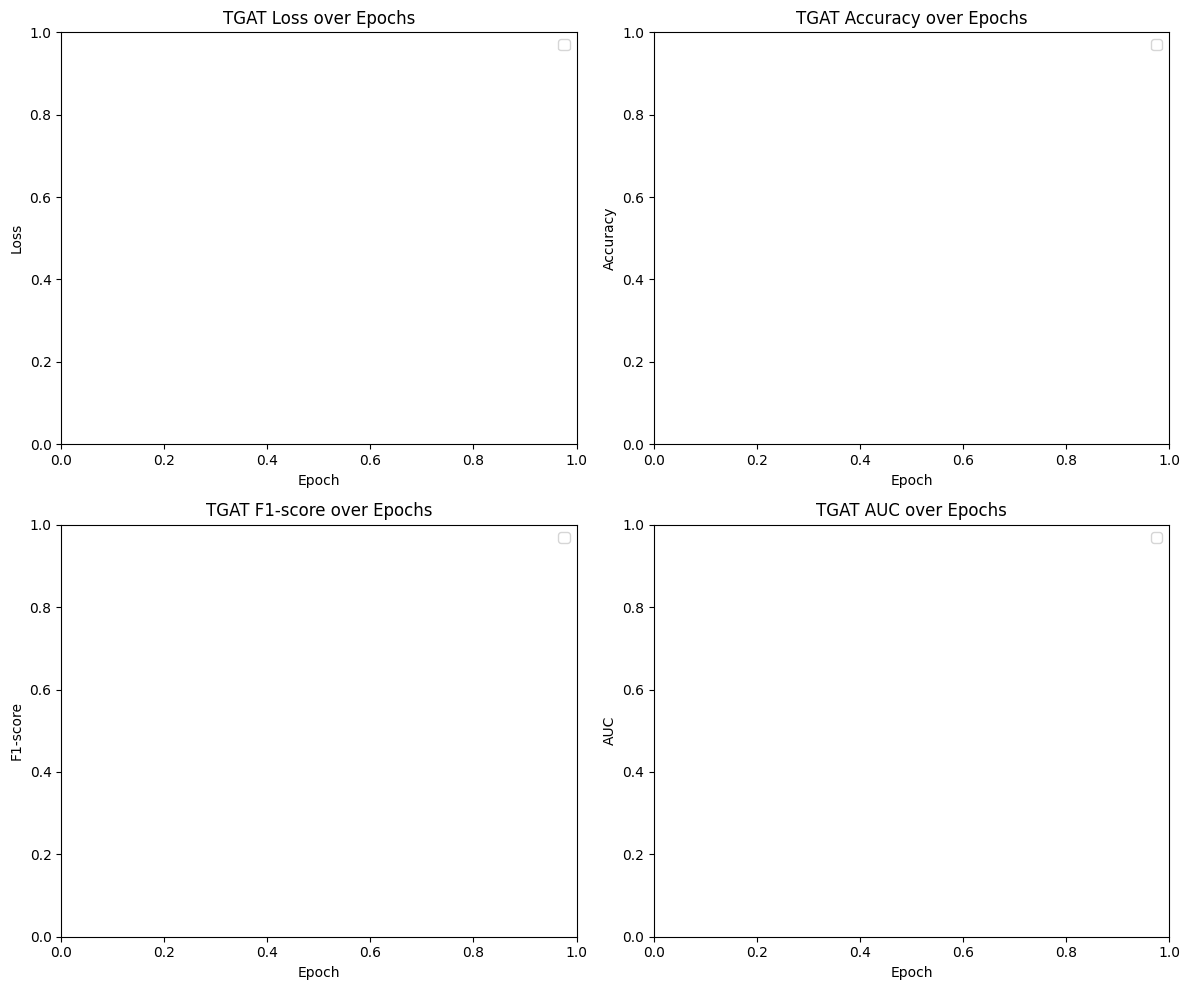


--- Final Evaluation of TGAT Model on Test Set (using best saved TGAT model) ---
Loading data from: ./processed_data_large/test_temporal_data.pt
Loading metadata from: ./processed_data_large/metadata.json
Data loaded: Nodes=22544, Edges=2
Metadata: NodeFeatDim=121, NumClasses(binary)=2, PosWeight=1.1452780961990356


Final TGAT Test Phase:   0%|          | 0/89 [00:00<?, ?it/s]

Final TGAT Test | Final TGAT Test Results Loss: 0.2037 | Acc: 0.5692 | Prec: 0.5692 | Rec: 0.9996 | F1: 0.7254 | AUC: 0.5008
{'Normal (0)': {'precision': 0.4444444444444444, 'recall': 0.0004119040263618577, 'f1-score': 0.0008230452674897119, 'support': 9711.0}, 'Attack (1)': {'precision': 0.569247836698469, 'recall': 0.9996103794903763, 'f1-score': 0.7254014928749152, 'support': 12833.0}, 'accuracy': 0.5691980127750177, 'macro avg': {'precision': 0.5068461405714567, 'recall': 0.5000111417583691, 'f1-score': 0.3631122690712024, 'support': 22544.0}, 'weighted avg': {'precision': 0.5154878232945109, 'recall': 0.5691980127750177, 'f1-score': 0.413283798379009, 'support': 22544.0}}


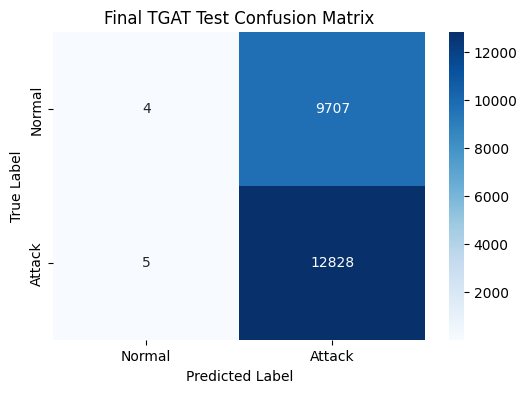



--- Stage 2: Sequence Aggregator Model Training & Evaluation ---
Loading data from: ./processed_data_large/train_temporal_data.pt
Loading metadata from: ./processed_data_large/metadata.json
Data loaded: Nodes=25192, Edges=2
Metadata: NodeFeatDim=121, NumClasses(binary)=2, PosWeight=1.1452780961990356
Loading data from: ./processed_data_large/test_temporal_data.pt
Loading metadata from: ./processed_data_large/metadata.json
Data loaded: Nodes=22544, Edges=2
Metadata: NodeFeatDim=121, NumClasses(binary)=2, PosWeight=1.1452780961990356
Generating TGAT embeddings for all events...


Generating Embeddings:   0%|          | 0/99 [00:00<?, ?it/s]

Generated 25192 event embeddings of dimension 256
Generating TGAT embeddings for all events...


Generating Embeddings:   0%|          | 0/89 [00:00<?, ?it/s]

Generated 22544 event embeddings of dimension 256

--- Training Sequence Aggregator Model (GRU) ---
Input Embedding Dim: 256, Sequence Length: 10, Step: 5
Sequence Model: Hidden=128, Layers=1, Dropout=0.2
Optimizer: Adam, LR=0.0001. Epochs: 20
Sequence Model Epoch 1/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.1781, Acc=0.9966, F1=0.9983


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0353 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0353, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 2/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0280, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0136 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0136, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 3/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0180, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0082 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0082, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 4/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0151, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0060 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0060, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 5/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0140, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0047 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0047, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 6/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0132, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0039 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0039, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 7/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0125, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0034 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0034, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 8/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0123, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0029 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0029, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 9/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0123, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0027 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0027, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 10/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0119, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0024 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0024, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 11/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0117, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0023 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0023, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 12/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0121, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0021 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0021, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 13/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0119, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0020 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0020, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 14/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0122, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0020 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0020, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 15/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0119, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0019 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0019, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 16/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0121, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0019 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0019, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 17/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0118, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0018 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0018, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 18/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0119, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0017 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0017, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 19/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0120, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0017 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0017, Acc=1.0000, F1=1.0000, AUC=N/A
Sequence Model Epoch 20/20


Train Sequence Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

  Seq Train: Loss=0.0121, Acc=0.9984, F1=0.9992


Val Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Val Seq Agg Seq Aggregator | Val Seq Agg Seq Results Loss: 0.0017 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
  Seq Val:   Loss=0.0017, Acc=1.0000, F1=1.0000, AUC=N/A
--- Sequence Aggregator Training Finished ---


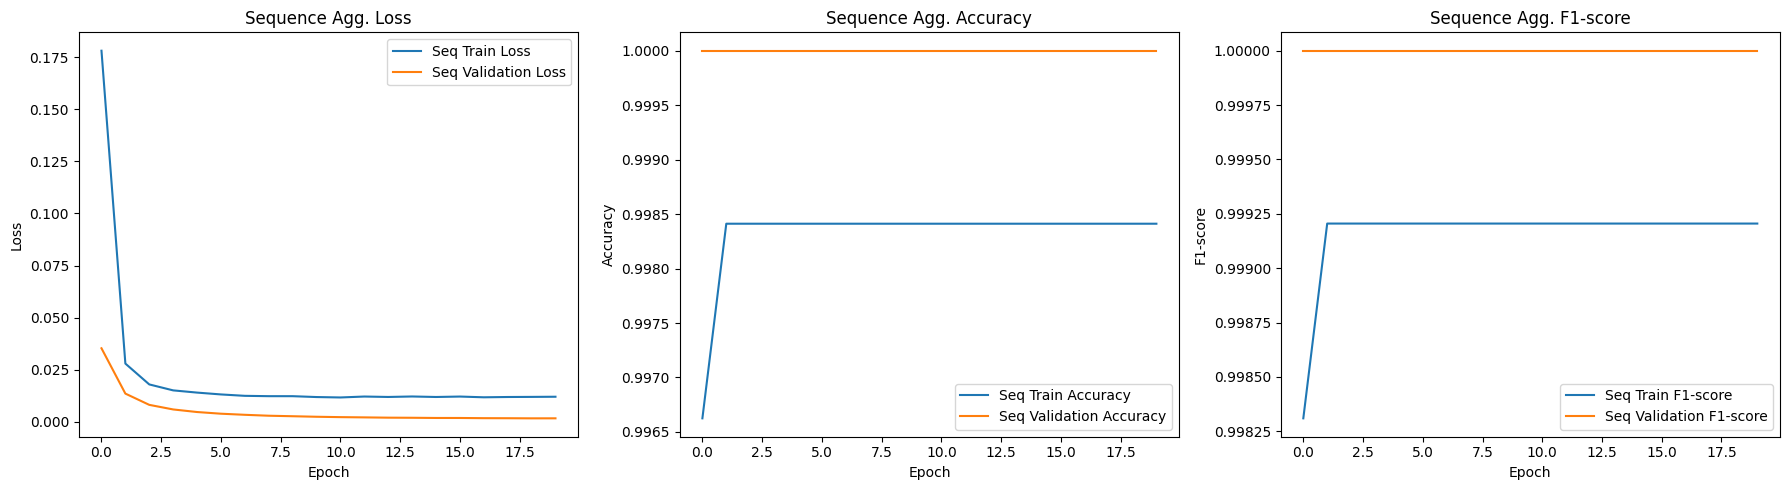


--- Final Evaluation of Sequence Aggregator Model on Test Sequences ---


Final Test Seq Agg Phase:   0%|          | 0/71 [00:00<?, ?it/s]

Final Test Seq Agg Seq Aggregator | Final Test Seq Agg Seq Results Loss: 0.0017 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000


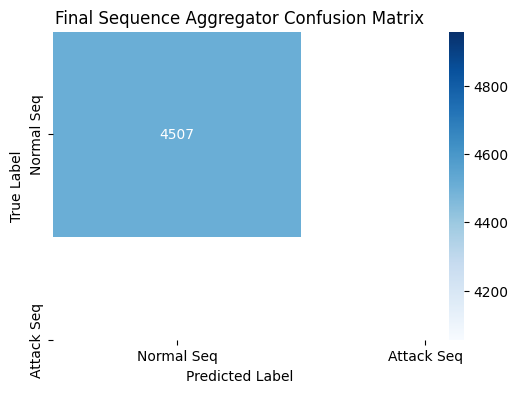

In [80]:
# Cell: Main execution block (MODIFIED to include Stage 2 Sequence Model Training)

if __name__ == '__main__': 
    if not all(os.path.exists(f_path) for f_path in [PROCESSED_TRAIN_FILE, PROCESSED_TEST_FILE, METADATA_FILE]):
        print(f"Error: Preprocessed data files not found in '{PROCESSED_DATA_DIR}'.")
        print("Please run the `preprocess_kdd_large.ipynb` notebook first to generate these files.")
    else:
        # --- STAGE 1: Train TGAT Model (as before) ---
        print("--- Stage 1: TGAT Model Training ---")
        history_tgat, final_trained_tgat_model = train_pipeline() # This trains and saves best TGAT model
        
        if not history_tgat:
            print("TGAT training failed. Aborting.")
        else:
            # ... (Plotting code for TGAT history remains the same) ...
            fig, axs = plt.subplots(2, 2, figsize=(12, 10))
            plot_metrics_map = [('Loss', 'loss'), ('Accuracy', 'acc'), ('F1-score', 'f1'), ('AUC', 'auc')]
            for i, (title, key_metric) in enumerate(plot_metrics_map):
                ax_current = axs[i//2, i%2]
                train_values = [v for v in history_tgat.get(f'train_{key_metric}', []) if v is not None and not np.isnan(v)]
                val_values = [v for v in history_tgat.get(f'val_{key_metric}', []) if v is not None and not np.isnan(v)]
                epochs_train = [j for j,v in enumerate(history_tgat.get(f'train_{key_metric}', [])) if v is not None and not np.isnan(v)]
                epochs_val = [j for j,v in enumerate(history_tgat.get(f'val_{key_metric}', [])) if v is not None and not np.isnan(v)]
                if epochs_train and train_values: ax_current.plot(epochs_train, train_values, label=f'Train {title}')
                if epochs_val and val_values: ax_current.plot(epochs_val, val_values, label=f'Validation {title}')
                ax_current.set_title(f'TGAT {title} over Epochs'); ax_current.set_xlabel('Epoch'); ax_current.set_ylabel(title); ax_current.legend()
            plt.tight_layout(); plt.show()

            print("\n--- Final Evaluation of TGAT Model on Test Set (using best saved TGAT model) ---")
            best_tgat_model_path = os.path.join(MODEL_SAVE_DIR, BEST_MODEL_NAME)
            if os.path.exists(best_tgat_model_path):
                with open(METADATA_FILE, 'r') as f_meta: meta_final_tgat = json.load(f_meta)
                
                tgat_output_dim = 1 if CLASSIFICATION_MODE == 'binary' else meta_final_tgat['NUM_CLASSES_MULTI']
                tgat_display_classes = meta_final_tgat.get('NUM_CLASSES_BINARY', 2) if CLASSIFICATION_MODE == 'binary' else tgat_output_dim
                tgat_node_feat_dim = meta_final_tgat['NODE_FEAT_DIM']
                
                tgat_model_for_eval = TGAT(
                    node_feat_dim=tgat_node_feat_dim, time_emb_dim=TIME_DIM, n_head=N_HEADS, 
                    n_layers=N_LAYERS, hidden_dim_per_layer=HIDDEN_DIM, 
                    num_classes=tgat_output_dim, dropout=DROPOUT 
                ).to(DEVICE)
                tgat_model_for_eval.load_state_dict(torch.load(best_tgat_model_path, map_location=DEVICE))
                
                tgat_test_data_cpu, _, _, tgat_pos_weight_cpu = load_processed_data(PROCESSED_TEST_FILE, METADATA_FILE, CLASSIFICATION_MODE)
                tgat_test_loader = TemporalNeighborLoader(tgat_test_data_cpu, BATCH_SIZE, NUM_NEIGHBORS, DEVICE, shuffle=False) # Using BATCH_SIZE for TGAT
                
                tgat_criterion_args = {}
                if CLASSIFICATION_MODE == 'binary':
                    if USE_FOCAL_LOSS: 
                        tgat_criterion = FocalLoss(gamma=2.0, pos_weight_for_bce=tgat_pos_weight_cpu.to(DEVICE) if tgat_pos_weight_cpu is not None else None, alpha=None)
                    else:
                        if tgat_pos_weight_cpu is not None: tgat_criterion_args['pos_weight'] = tgat_pos_weight_cpu.to(DEVICE)
                        tgat_criterion = nn.BCEWithLogitsLoss(**tgat_criterion_args)
                else: 
                    tgat_criterion = nn.CrossEntropyLoss(**tgat_criterion_args)
                
                eval_results_tgat = evaluate_model( # This is the event-level evaluation
                    tgat_model_for_eval, tgat_test_loader, tgat_criterion, 
                    phase='Final TGAT Test', return_embeddings_and_ids=True
                )
                # Unpack all, including embeddings for potential use (though we regenerate for sequence model for clarity)
                _, _, _, _, _, _, eval_y_true_tgat, eval_y_pred_tgat, final_class_report_dict_tgat, _, _, _ = eval_results_tgat
                # ... (Print TGAT's final metrics and confusion matrix as before) ...
                print_metrics("Final TGAT Test", eval_results_tgat[0], eval_results_tgat[1], eval_results_tgat[2], eval_results_tgat[3], eval_results_tgat[4], eval_results_tgat[5], phase='Final TGAT Test Results', class_report=str(final_class_report_dict_tgat))
                cm_class_names_tgat = ['Normal', 'Attack'] if CLASSIFICATION_MODE == 'binary' else [str(i) for i in range(tgat_display_classes)]
                if eval_y_true_tgat and eval_y_pred_tgat: 
                    plot_confusion_matrix_custom(eval_y_true_tgat, eval_y_pred_tgat, class_names=cm_class_names_tgat, title='Final TGAT Test Confusion Matrix')


                # --- STAGE 2: Train and Evaluate Sequence Aggregator Model ---
                print("\n\n--- Stage 2: Sequence Aggregator Model Training & Evaluation ---")
                
                # 1. Load best TGAT model again (or use final_trained_tgat_model if train_pipeline returns it directly)
                # We need it for generating embeddings.
                tgat_model_for_embeddings_stage2 = TGAT( # Re-init for clarity, or use the one from eval
                    node_feat_dim=tgat_node_feat_dim, time_emb_dim=TIME_DIM, n_head=N_HEADS,
                    n_layers=N_LAYERS, hidden_dim_per_layer=HIDDEN_DIM,
                    num_classes=tgat_output_dim, dropout=DROPOUT
                ).to(DEVICE)
                tgat_model_for_embeddings_stage2.load_state_dict(torch.load(best_tgat_model_path, map_location=DEVICE))
                tgat_model_for_embeddings_stage2.eval()

                # 2. Generate event embeddings
                train_data_cpu_seq, _, _, _ = load_processed_data(PROCESSED_TRAIN_FILE, METADATA_FILE, CLASSIFICATION_MODE)
                test_data_cpu_seq, _, _, _ = load_processed_data(PROCESSED_TEST_FILE, METADATA_FILE, CLASSIFICATION_MODE)

                # Ensure event labels are binary for sequence task
                train_event_embeddings, train_event_labels_for_seq = get_all_event_embeddings(
                    tgat_model_for_embeddings_stage2, train_data_cpu_seq, BATCH_SIZE_SEQ_EMBED_GEN, NUM_NEIGHBORS, DEVICE
                )
                test_event_embeddings, test_event_labels_for_seq = get_all_event_embeddings(
                    tgat_model_for_embeddings_stage2, test_data_cpu_seq, BATCH_SIZE_SEQ_EMBED_GEN, NUM_NEIGHBORS, DEVICE
                )

                if train_event_embeddings.numel() == 0:
                    print("Failed to generate train event embeddings. Skipping sequence model training.")
                else:
                    # Squeeze labels if they are (N,1) to (N) and ensure they are binary
                    train_event_labels_binary_squeezed = (train_event_labels_for_seq.squeeze() > 0).long() if CLASSIFICATION_MODE == 'multiclass' else train_event_labels_for_seq.squeeze().long()
                    test_event_labels_binary_squeezed = (test_event_labels_for_seq.squeeze() > 0).long() if CLASSIFICATION_MODE == 'multiclass' else test_event_labels_for_seq.squeeze().long()


                    # 3. Create sequences
                    train_seq_labels_list, train_padded_sequences, train_seq_lengths = create_embedding_sequences(
                        train_event_embeddings, train_event_labels_binary_squeezed, 
                        SEQUENCE_LENGTH, STEP_SIZE, SEQ_LABEL_MODE, 'binary'
                    )
                    test_seq_labels_list, test_padded_sequences, test_seq_lengths = create_embedding_sequences(
                        test_event_embeddings, test_event_labels_binary_squeezed, 
                        SEQUENCE_LENGTH, STEP_SIZE, SEQ_LABEL_MODE, 'binary'
                    )

                    if train_padded_sequences.numel() == 0:
                        print("No training sequences generated. Skipping sequence model training.")
                    else:
                        train_sequence_dataset = EmbeddingSequenceDataset(train_padded_sequences, train_seq_labels_list, train_seq_lengths)
                        train_sequence_loader = DataLoader(train_sequence_dataset, batch_size=BATCH_SIZE_SEQ_MODEL, shuffle=True, collate_fn=collate_fn_packed_fixed_length)
                        
                        test_sequence_dataset = None
                        test_sequence_loader = None
                        if test_padded_sequences.numel() > 0:
                            test_sequence_dataset = EmbeddingSequenceDataset(test_padded_sequences, test_seq_labels_list, test_seq_lengths)
                            test_sequence_loader = DataLoader(test_sequence_dataset, batch_size=BATCH_SIZE_SEQ_MODEL, shuffle=False, collate_fn=collate_fn_packed_fixed_length)
                        else:
                            print("No test sequences generated for evaluation of sequence model.")

                        # 4. Define and train sequence model
                        seq_model_input_dim = train_event_embeddings.shape[1] # Should match SEQ_MODEL_EMBEDDING_DIM_ACTUAL
                        
                        sequence_model = EventSequenceAggregator(
                            embedding_dim=seq_model_input_dim,
                            hidden_dim=SEQ_MODEL_HIDDEN_DIM,
                            num_layers=SEQ_MODEL_NUM_LAYERS,
                            num_classes=1, # Binary sequence classification
                            dropout=SEQ_MODEL_DROPOUT,
                            rnn_type=SEQ_MODEL_RNN_TYPE
                        ).to(DEVICE)

                        criterion_seq = nn.BCEWithLogitsLoss() # Add pos_weight if needed based on train_seq_labels_list balance
                        optimizer_seq = optim.Adam(sequence_model.parameters(), lr=LEARNING_RATE_SEQ_MODEL)

                        print(f"\n--- Training Sequence Aggregator Model ({SEQ_MODEL_RNN_TYPE}) ---")
                        print(f"Input Embedding Dim: {seq_model_input_dim}, Sequence Length: {SEQUENCE_LENGTH}, Step: {STEP_SIZE}")
                        print(f"Sequence Model: Hidden={SEQ_MODEL_HIDDEN_DIM}, Layers={SEQ_MODEL_NUM_LAYERS}, Dropout={SEQ_MODEL_DROPOUT}")
                        print(f"Optimizer: Adam, LR={LEARNING_RATE_SEQ_MODEL}. Epochs: {EPOCHS_SEQ_MODEL}")

                        history_seq_agg = {'train_loss': [], 'train_acc': [], 'train_f1': [], 
                                           'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []}

                        for epoch_seq in range(EPOCHS_SEQ_MODEL):
                            print(f"Sequence Model Epoch {epoch_seq+1}/{EPOCHS_SEQ_MODEL}")
                            train_loss_s, train_acc_s, _, _, train_f1_s = train_sequence_epoch(
                                sequence_model, train_sequence_loader, optimizer_seq, criterion_seq, DEVICE
                            )
                            history_seq_agg['train_loss'].append(train_loss_s)
                            history_seq_agg['train_acc'].append(train_acc_s)
                            history_seq_agg['train_f1'].append(train_f1_s)
                            print(f"  Seq Train: Loss={train_loss_s:.4f}, Acc={train_acc_s:.4f}, F1={train_f1_s:.4f}")

                            if test_sequence_loader:
                                val_loss_s, val_acc_s, _, _, val_f1_s, val_auc_s, _, _ = evaluate_sequence_model(
                                    sequence_model, test_sequence_loader, criterion_seq, DEVICE, phase="Val Seq Agg"
                                )
                                history_seq_agg['val_loss'].append(val_loss_s)
                                history_seq_agg['val_acc'].append(val_acc_s)
                                history_seq_agg['val_f1'].append(val_f1_s)
                                history_seq_agg['val_auc'].append(val_auc_s if val_auc_s is not None else np.nan)
                                # ** CORRECTED PRINT STATEMENT for Seq Val ** (這是您需要替換或插入的部分)
                                val_loss_s_str = f"{val_loss_s:.4f}" if val_loss_s is not None and not np.isnan(val_loss_s) else "N/A" # [cite: 483]
                                val_acc_s_str = f"{val_acc_s:.4f}" if val_acc_s is not None and not np.isnan(val_acc_s) else "N/A" # [cite: 483]
                                val_f1_s_str = f"{val_f1_s:.4f}" if val_f1_s is not None and not np.isnan(val_f1_s) else "N/A" # [cite: 478]
                                val_auc_s_str = f"{val_auc_s:.4f}" if val_auc_s is not None and not np.isnan(val_auc_s) else "N/A" # [cite: 478]
                                print(f"  Seq Val:   Loss={val_loss_s_str}, Acc={val_acc_s_str}, F1={val_f1_s_str}, AUC={val_auc_s_str}") # [cite: 478]
                            else: # No test data for sequence model
                                for k_val_s in ['val_loss', 'val_acc', 'val_f1', 'val_auc']: history_seq_agg[k_val_s].append(float('nan'))
                        
                        print("--- Sequence Aggregator Training Finished ---")

                        # Plot sequence model training history
                        fig_seq, axs_seq = plt.subplots(1, 3, figsize=(18, 5)) # Loss, Acc, F1
                        plot_metrics_seq_map = [('Loss', 'loss'), ('Accuracy', 'acc'), ('F1-score', 'f1')]
                        for i_seq, (title_s, key_metric_s) in enumerate(plot_metrics_seq_map):
                            ax_s_current = axs_seq[i_seq]
                            train_values_s = [v for v in history_seq_agg.get(f'train_{key_metric_s}', []) if v is not None and not np.isnan(v)]
                            val_values_s = [v for v in history_seq_agg.get(f'val_{key_metric_s}', []) if v is not None and not np.isnan(v)]
                            epochs_train_s = [j for j,v in enumerate(history_seq_agg.get(f'train_{key_metric_s}', [])) if v is not None and not np.isnan(v)]
                            epochs_val_s = [j for j,v in enumerate(history_seq_agg.get(f'val_{key_metric_s}', [])) if v is not None and not np.isnan(v)]

                            if epochs_train_s and train_values_s: ax_s_current.plot(epochs_train_s, train_values_s, label=f'Seq Train {title_s}')
                            if epochs_val_s and val_values_s: ax_s_current.plot(epochs_val_s, val_values_s, label=f'Seq Validation {title_s}')
                            ax_s_current.set_title(f'Sequence Agg. {title_s}'); ax_s_current.set_xlabel('Epoch'); ax_s_current.set_ylabel(title_s); ax_s_current.legend()
                        plt.tight_layout(); plt.show()

                        # Final evaluation of sequence model on test sequences
                        if test_sequence_loader:
                            print("\n--- Final Evaluation of Sequence Aggregator Model on Test Sequences ---")
                            _, _, _, _, _, _, final_seq_true, final_seq_pred = evaluate_sequence_model(
                                sequence_model, test_sequence_loader, criterion_seq, DEVICE, phase="Final Test Seq Agg"
                            )
                            if final_seq_true and final_seq_pred:
                                plot_confusion_matrix_custom(final_seq_true, final_seq_pred, class_names=['Normal Seq', 'Attack Seq'], title='Final Sequence Aggregator Confusion Matrix')
            else:
                print(f"Best TGAT model file not found at: {best_tgat_model_path}. Skipping TGAT final evaluation and Stage 2.")

## 10. How to Run & Notes
- **Ensure Preprocessing is Done**: Run `preprocess_kdd_large.ipynb` first.
- **Adjust Configuration**: Check paths and hyperparameters in Cell 2.
- **Run All Cells**: This will train, evaluate, save the best model, and plot metrics.
- **Memory for `TemporalNeighborLoader`**:
    - The current loader sends the *entire* graph's features (`self.temporal_data.x`) and timestamps (`self.temporal_data.ts`) to the specified `device` *for each batch*.
    - **If `self.temporal_data.x` (all node features for the entire dataset) is too large to fit on the GPU, this will cause an Out-Of-Memory (OOM) error.**
    - **For truly massive graphs**: The loader and model interaction need modification. For example, keep full data on CPU, loader passes indices, model fetches only necessary data slices to GPU. This is a more advanced optimization not implemented here but crucial for >GPU memory graphs. This script currently assumes the full feature/timestamp tensors fit on the device.